In [31]:
import pickle
import numpy as np
from functools import partial
from functools import wraps
from scipy import stats
from nolds import lyap_r
from nolds import lyap_e
from gtda.time_series import takens_embedding_optimal_parameters
from matplotlib import pyplot as plt
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from trajectories import generate_trajectories
from plots_and_correlates import get_correlation
from plots_and_correlates import plot_lce_estimate_and_correlation
from lca_supervised_learning import score_classification
from lca_supervised_learning import score_regression
from lca_supervised_learning import score_regression_pos
from ipyparallel import interactive
from ipyparallel import require



In [32]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [33]:
tseriesChaos = importr("tseriesChaos")
lyap_k = tseriesChaos.lyap_k

In [34]:
SEED = 42
SAMPLES = 500
LENGTH = 500
experimental_data = generate_trajectories(
    RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES
)


Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [35]:
logistic_trajectories = experimental_data["logistic"]["trajectories"]
logistic_lces = experimental_data["logistic"]["lces"]
logistic_control_params = experimental_data["logistic"]["sys_params"]

In [36]:
henon_trajectories = experimental_data["henon"]["trajectories"]
henon_lces = experimental_data["henon"]["lces"]
henon_control_params = experimental_data["henon"]["sys_params"]

In [37]:
ikeda_trajectories = experimental_data["ikeda"]["trajectories"]
ikeda_lces = experimental_data["ikeda"]["lces"]
ikeda_control_params = experimental_data["ikeda"]["sys_params"]

In [38]:
tinkerbell_trajectories = experimental_data["tinkerbell"]["trajectories"]
tinkerbell_lces = experimental_data["tinkerbell"]["lces"]
tinkerbell_control_params = experimental_data["tinkerbell"]["sys_params"]

In [39]:
@require(takens_embedding_optimal_parameters)
def get_best_params(ts, max_delay=50, max_dim=8):
    delay, dim = takens_embedding_optimal_parameters(ts, max_delay, max_dim)
    return delay, dim

In [40]:
def trajectories_to_r_vecs(trajectories):
    return [robjects.FloatVector(ts) for ts in trajectories]

In [41]:

@require(get_best_params, lyap_k=lyap_k)
def kantz_estimator(
    ts,
    dim=None,
    delay=None,
    theiler_window=5,
    k_neighbours=2,
    max_num_points=400,
    num_iterations=20,
    neighbour_radius=1.1,
):
    """Use R's `tseriesChaos` package and function `lyap_k` to estimate max of Lyapunov spectrum."""
    if dim is None or delay is None:
        delay_, dim_ = get_best_params(ts)
        if dim is None:
            dim = dim_
        if delay is None:
            delay = delay_
    num_points = min(max_num_points, len(ts) - (((dim - 1) * delay) + 1))
    lyapunov_spectrum_estimate = lyap_k(
        ts,
        dim,
        delay,
        t=theiler_window,
        k=k_neighbours,
        ref=num_points,
        s=num_iterations,
        eps=neighbour_radius,
    )
    return max(lyapunov_spectrum_estimate)


In [42]:
from ts2vg import HorizontalVG as HVG
from scipy.stats import wasserstein_distance

@require(np)
def safe_lyap(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            result = func(*args, **kwargs)
        except Exception as err:
            message = getattr(err, "message", repr(err))
            print("WARNING: Lyapunov function failed for some reason")
            print("MESSAGE:", message)
            return np.nan
        return result
    return wrapper
    

def generate_classical_estimates(
    sys_name,
    param_name,
    trajectories,
    control_params,
    actual_lces,
    show_plot=True,
):
    # store results to be returned
    correlations_and_scores = {}

    rosenstein_estimates = lbv.map_sync(safe_lyap(lyap_r), trajectories)
    rosenstein_estimates = np.array(rosenstein_estimates)

    eckmann_estimates = lbv.map_sync(safe_lyap(lyap_e), trajectories)
    eckmann_estimates = np.array(eckmann_estimates)
    eckmann_estimates = np.max(eckmann_estimates, axis=1)

    kantz_estimates = lbv.map_sync(safe_lyap(kantz_estimator), trajectories_to_r_vecs(trajectories))
    kantz_estimates = np.array(kantz_estimates)


    # compute the correlations of the estimates with the actual lyapunov values
    for estimate_name, estimates in {
        "Rosenstein": rosenstein_estimates,
        "Eckmann": eckmann_estimates,
        "Kantz": kantz_estimates
    }.items():
        estimates = np.array(estimates)
        sequence_length = len(trajectories[0]) - 1
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] = plot_lce_estimate_and_correlation(
            estimate_name,
            sys_name,
            param_name,
            estimates,
            actual_lces,
            control_params,
            sequence_length,
            sharey=False,
            show_plot=show_plot,
            plot_actual=True,
            logy=True if estimate_name == "Kantz" else False
        )
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] |= {
            "classification_f1": score_classification(estimates.reshape(-1,1), actual_lces),
            "regression_neg_mean_absolute": score_regression(estimates.reshape(-1,1), actual_lces),
            "pos_regression_neg_mean_absolute": score_regression_pos(estimates.reshape(-1,1), actual_lces)
        }

    return correlations_and_scores


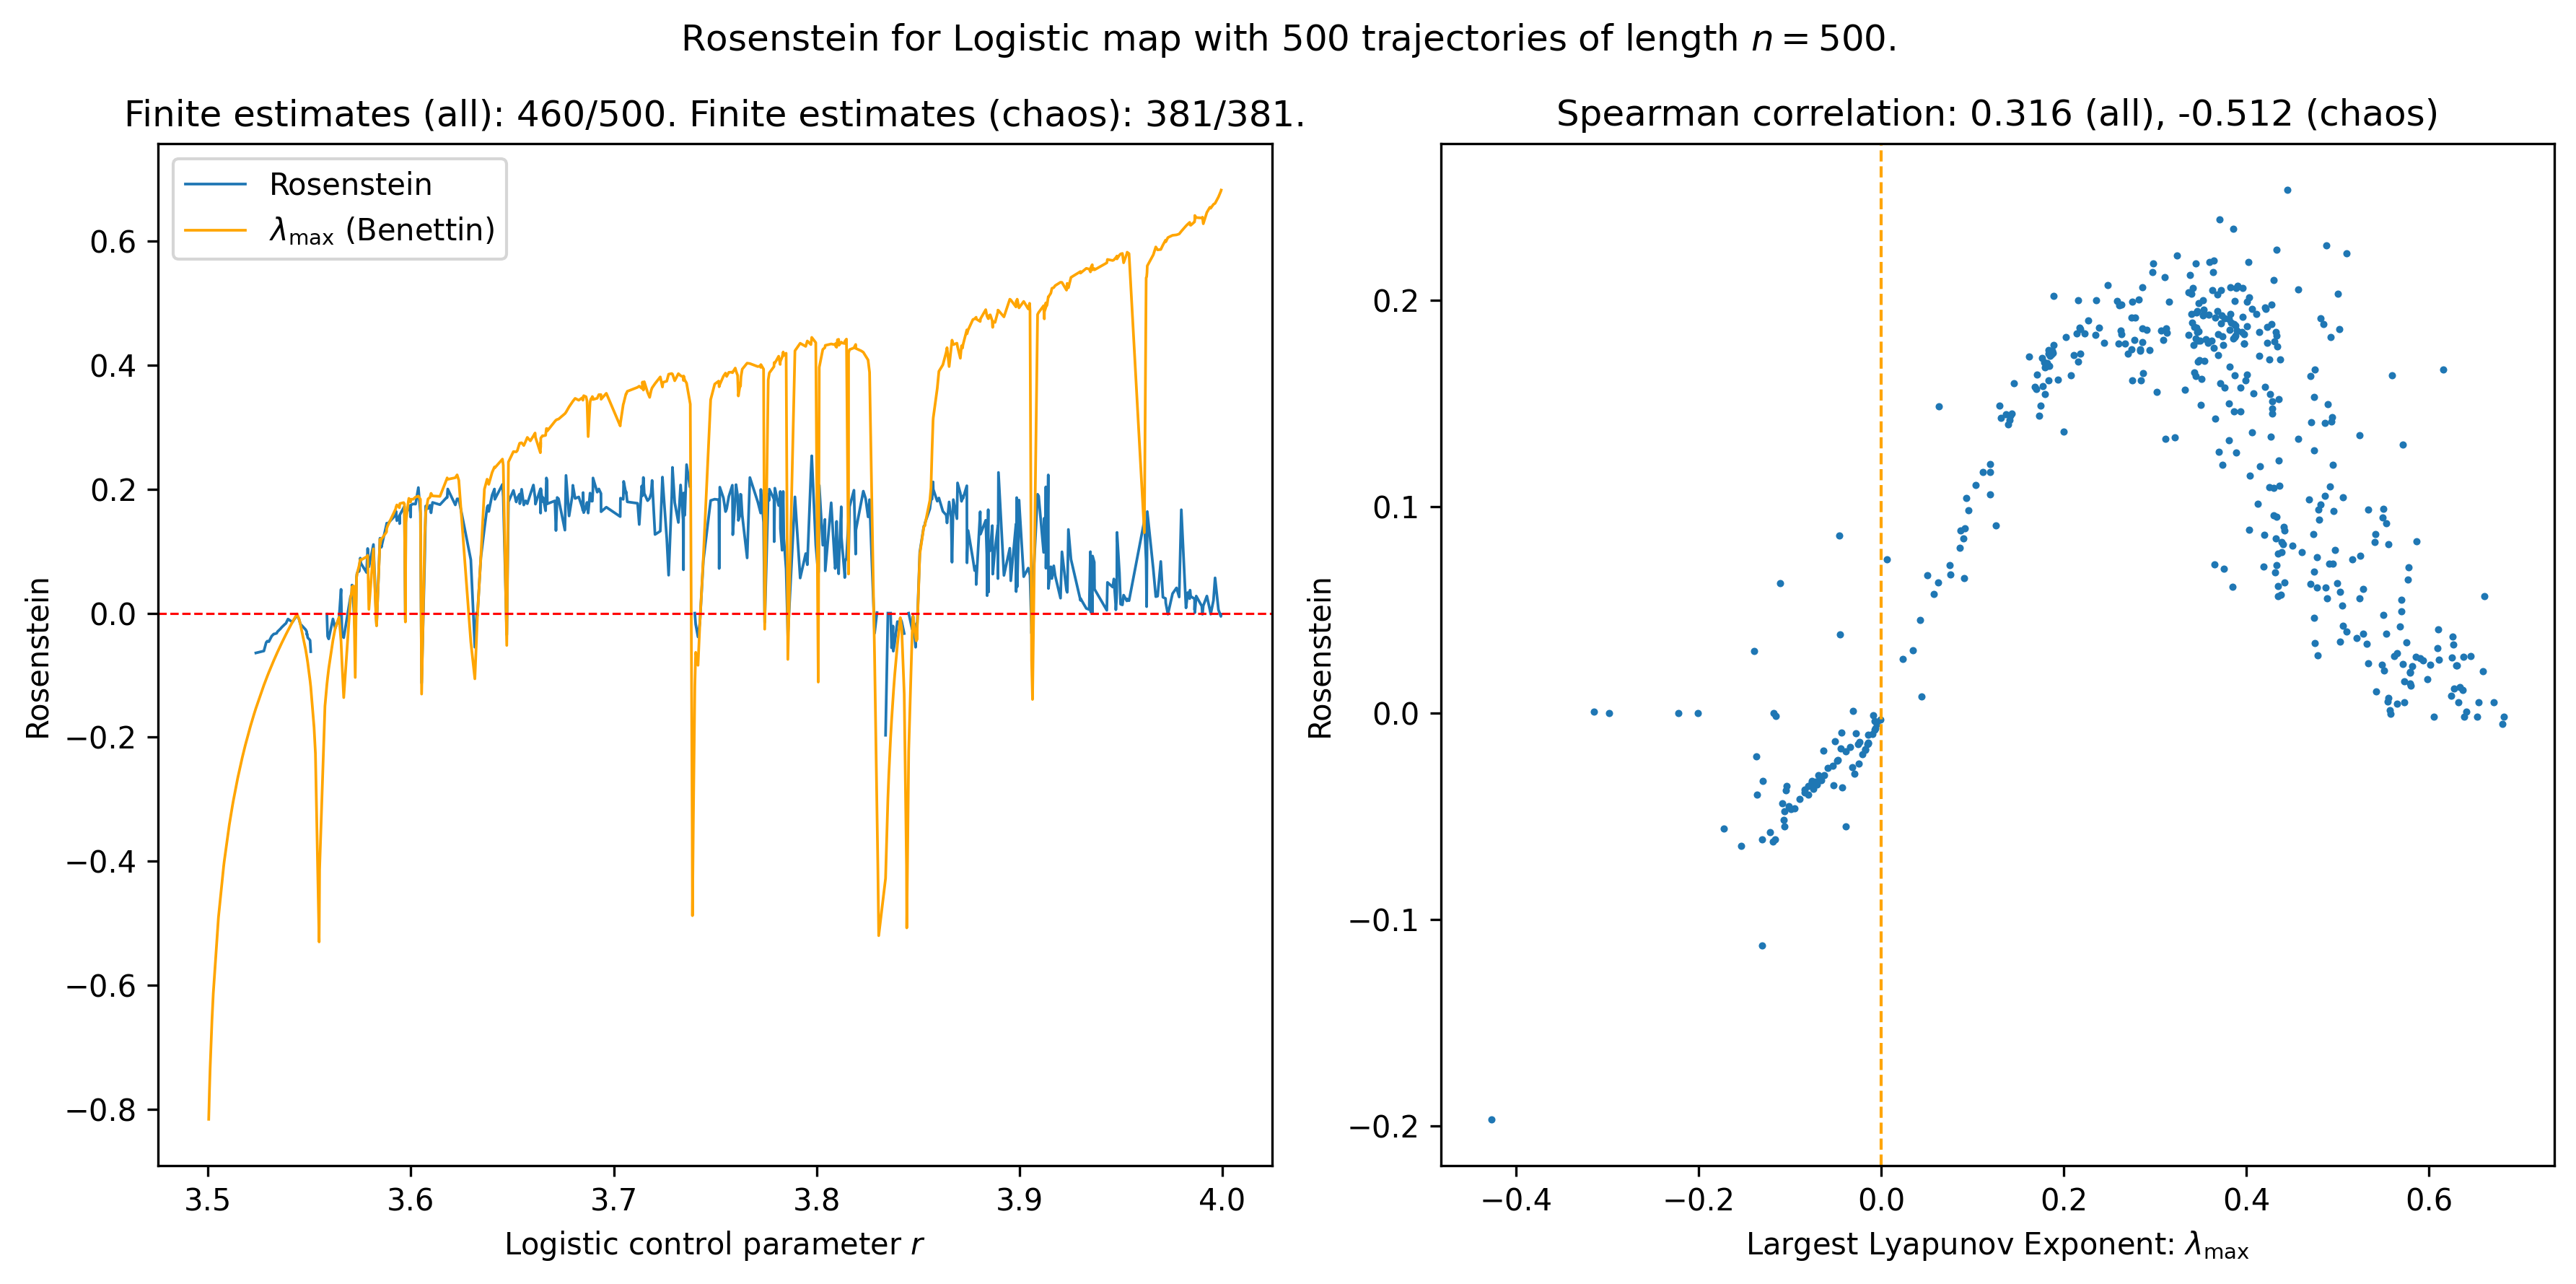

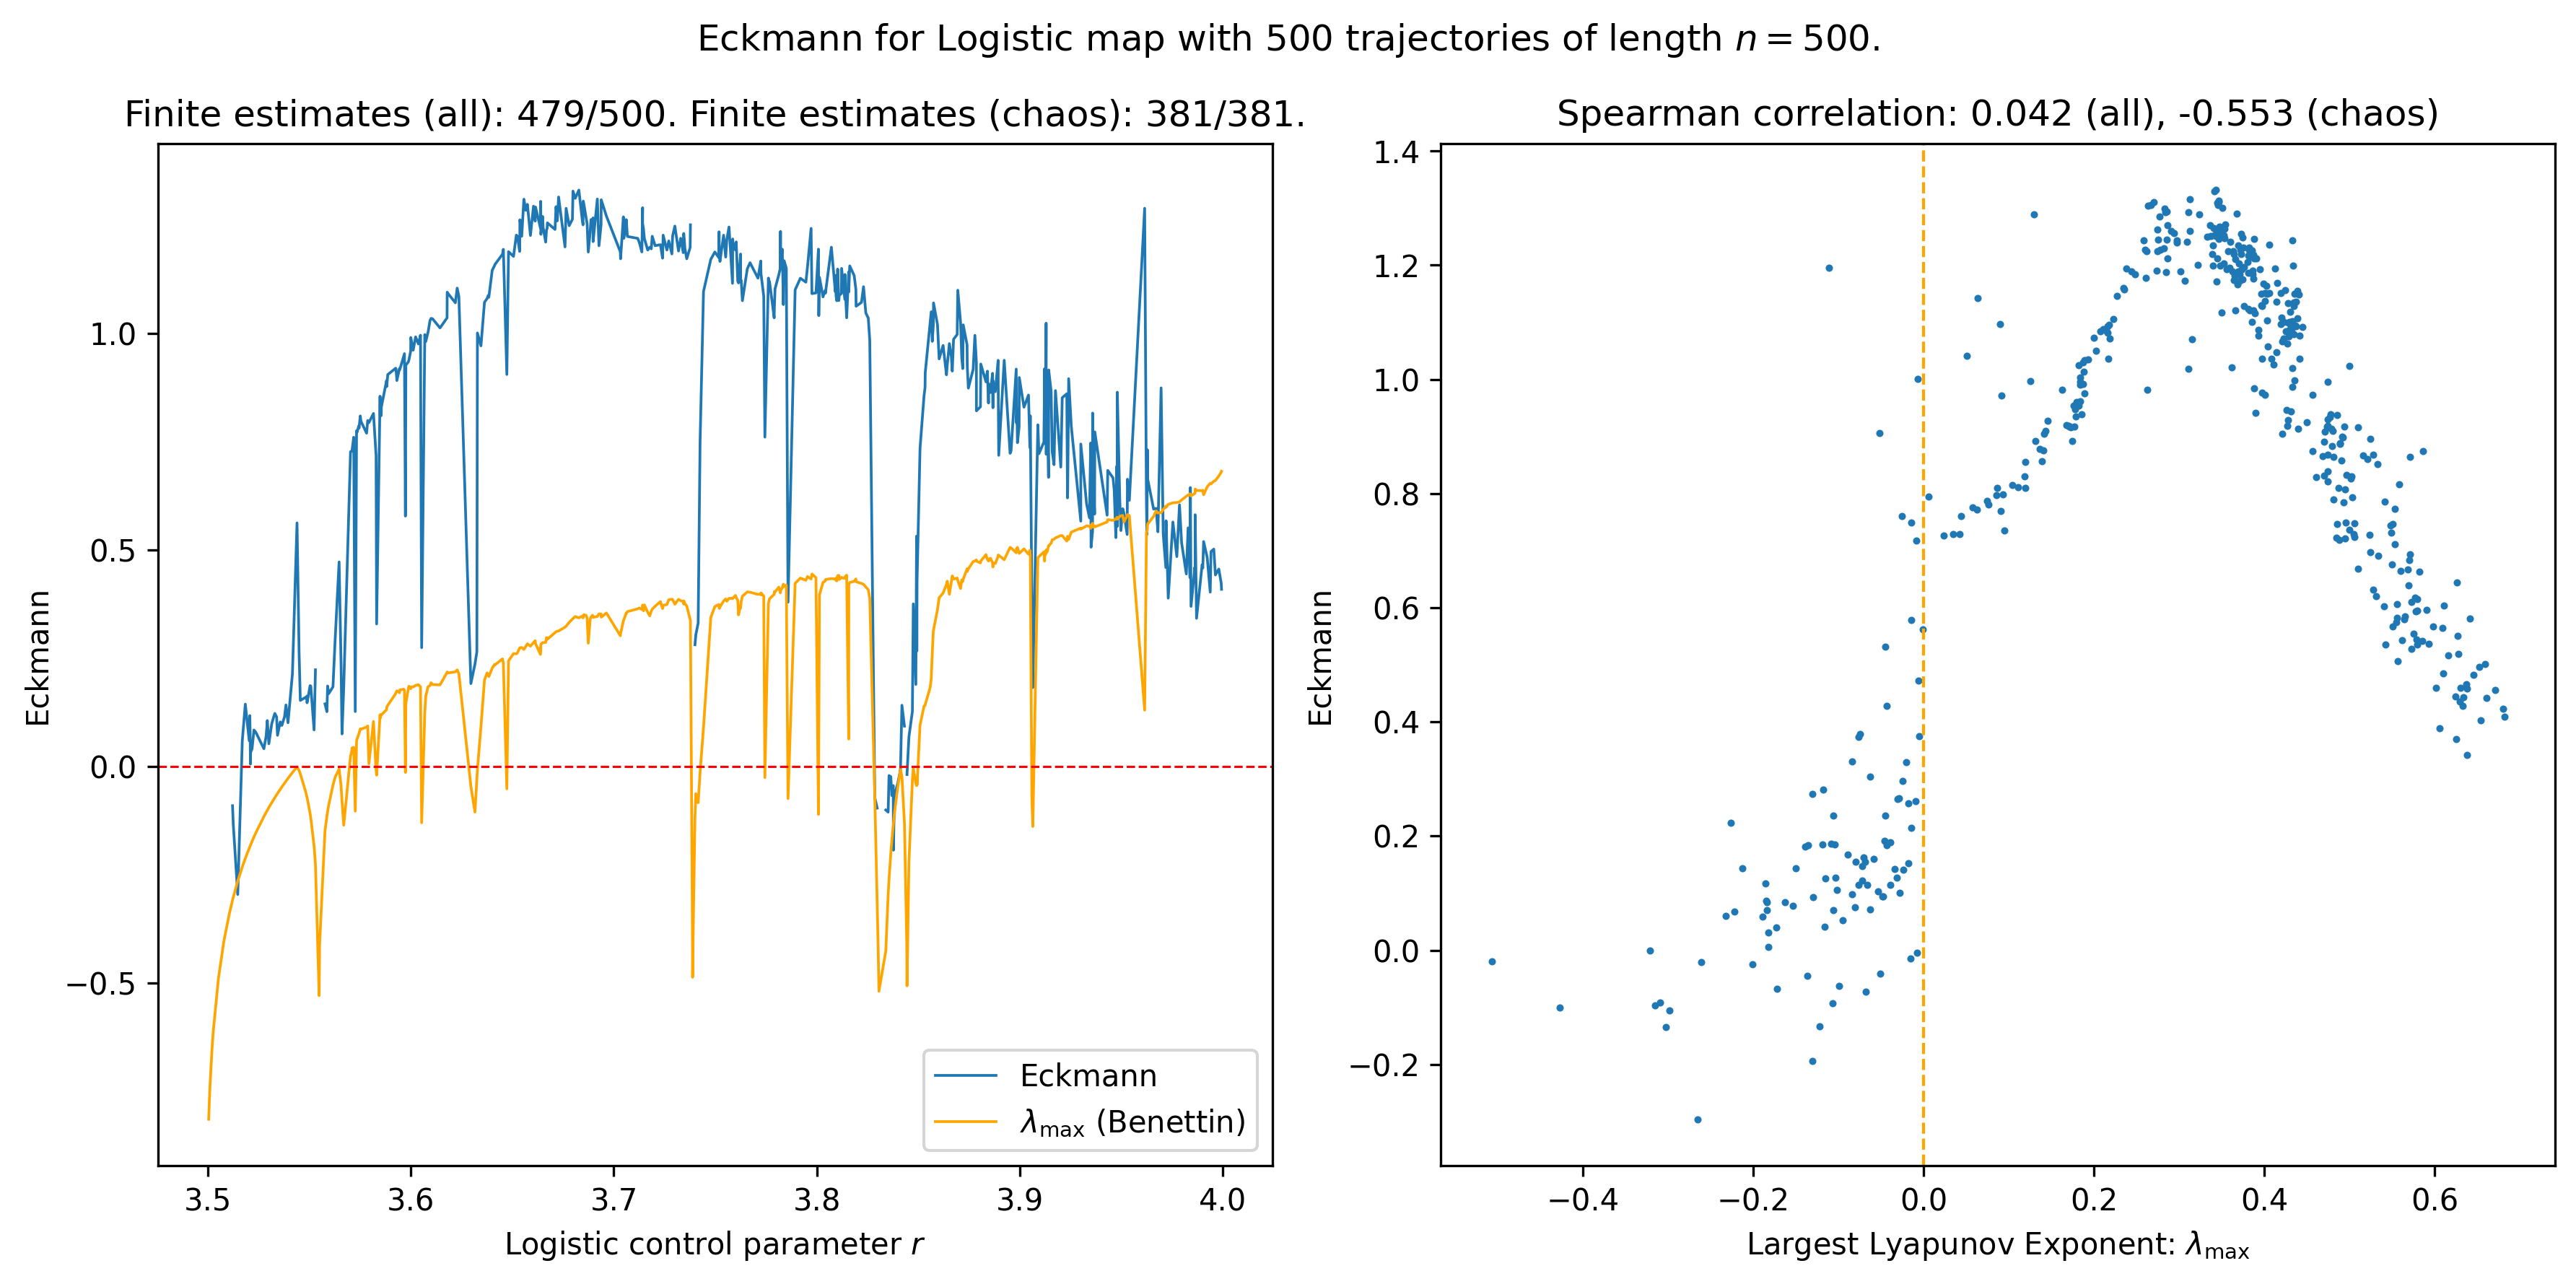

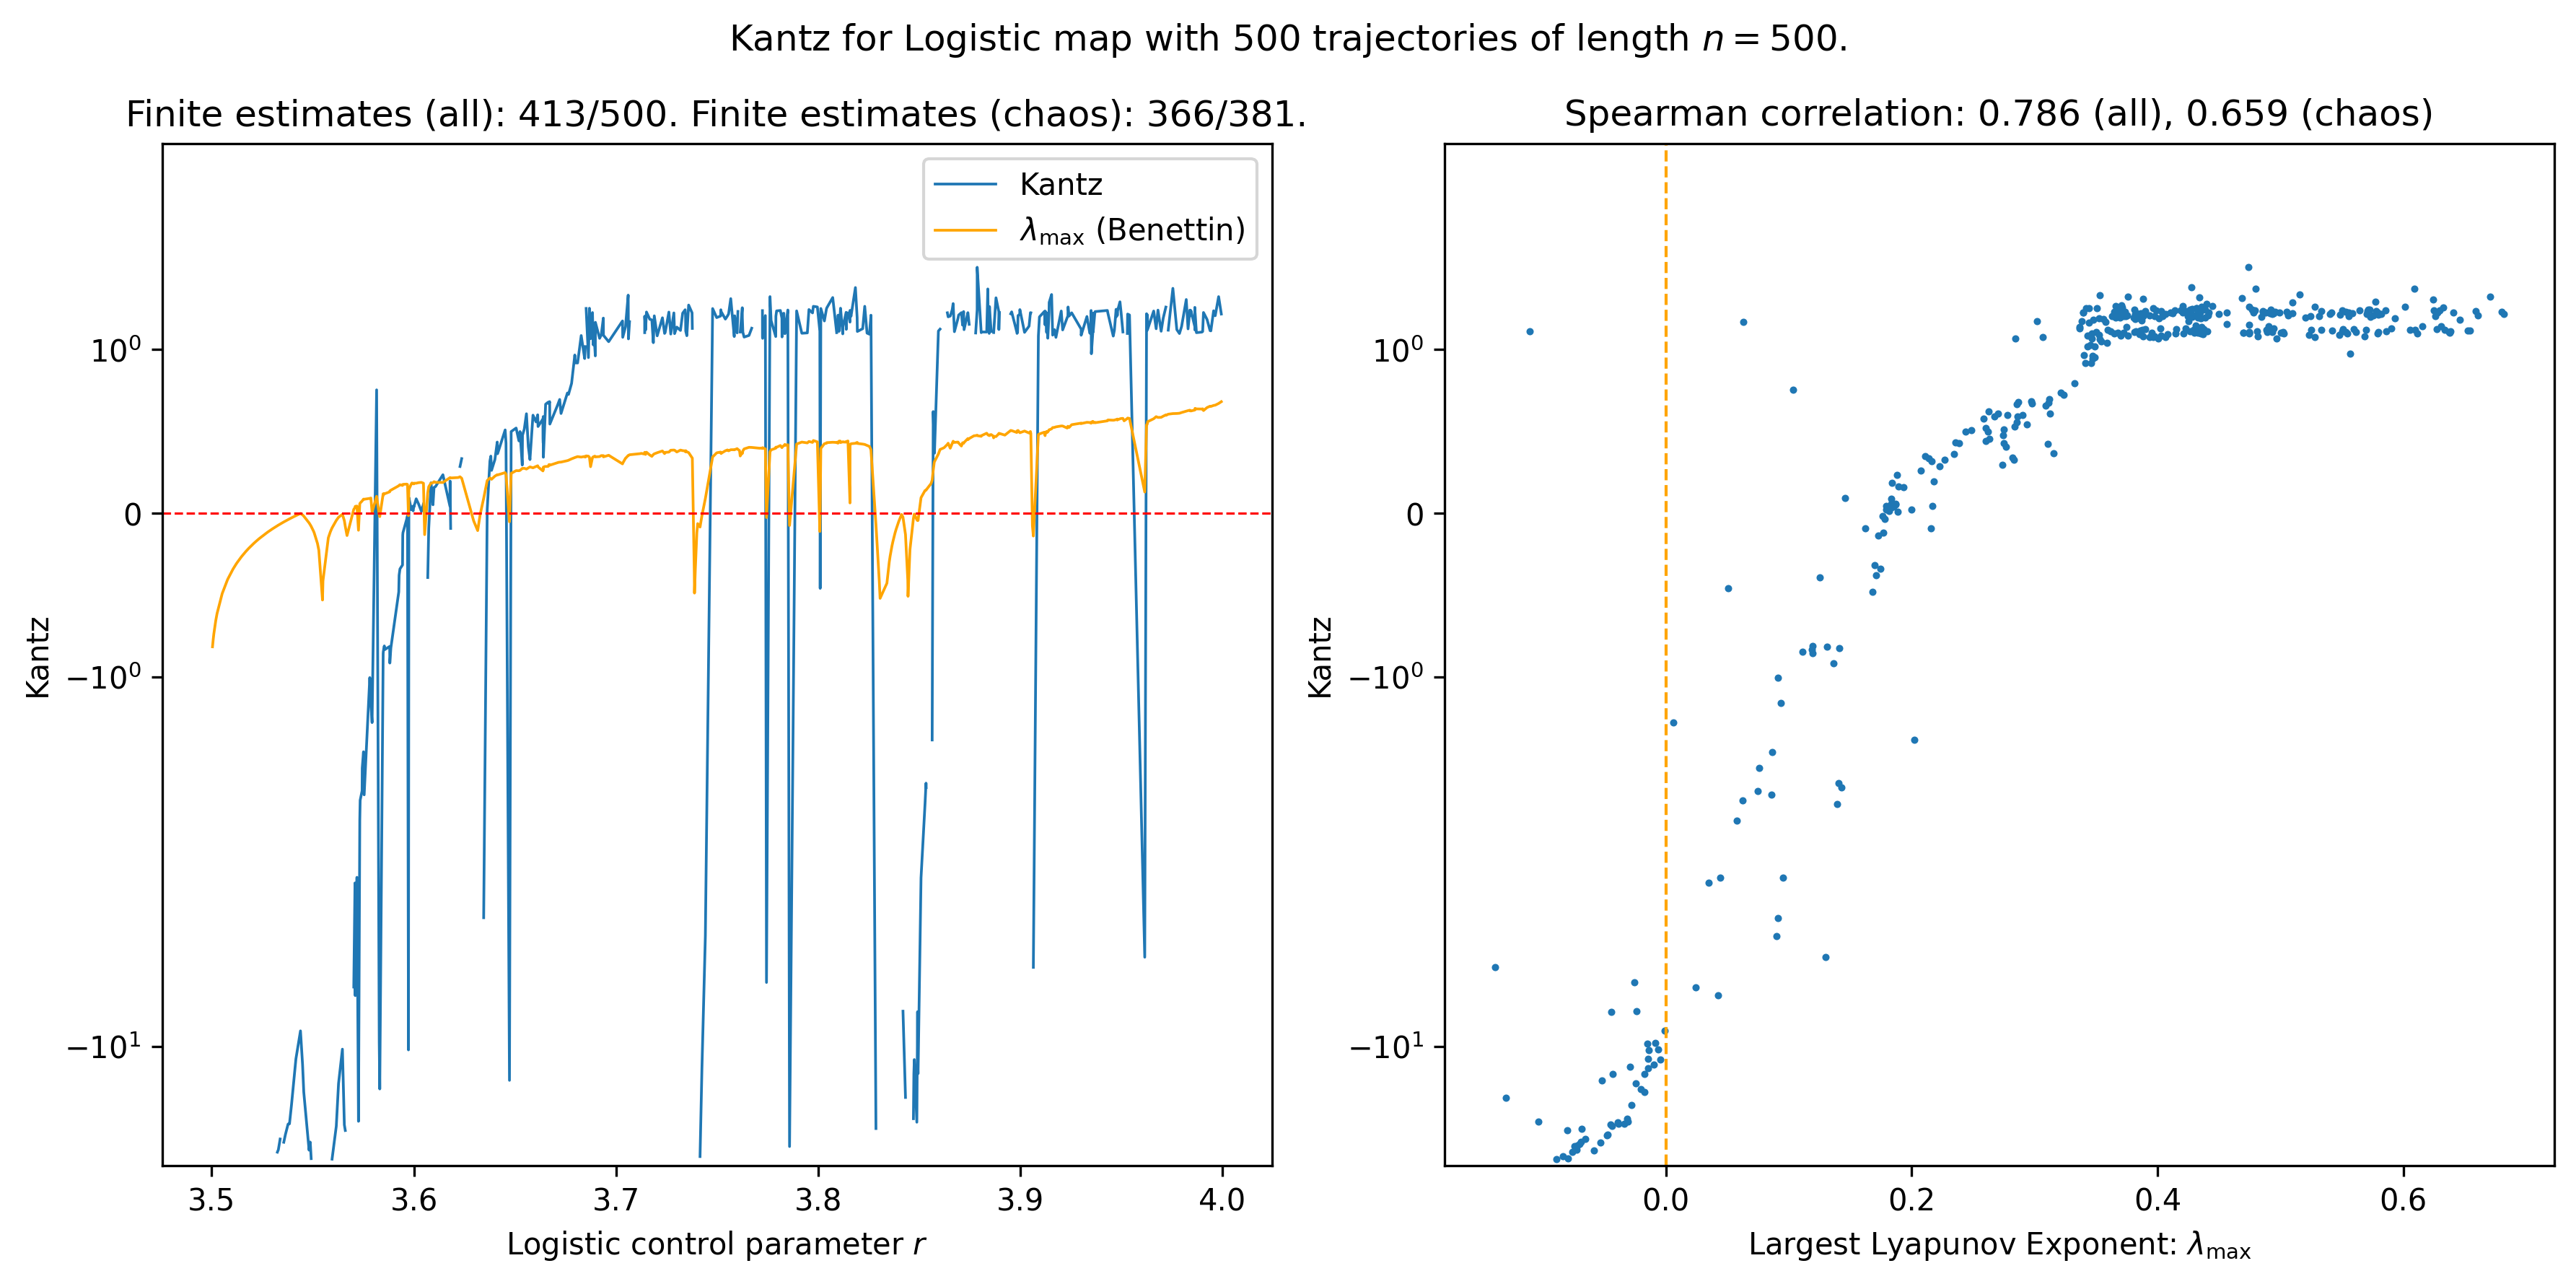

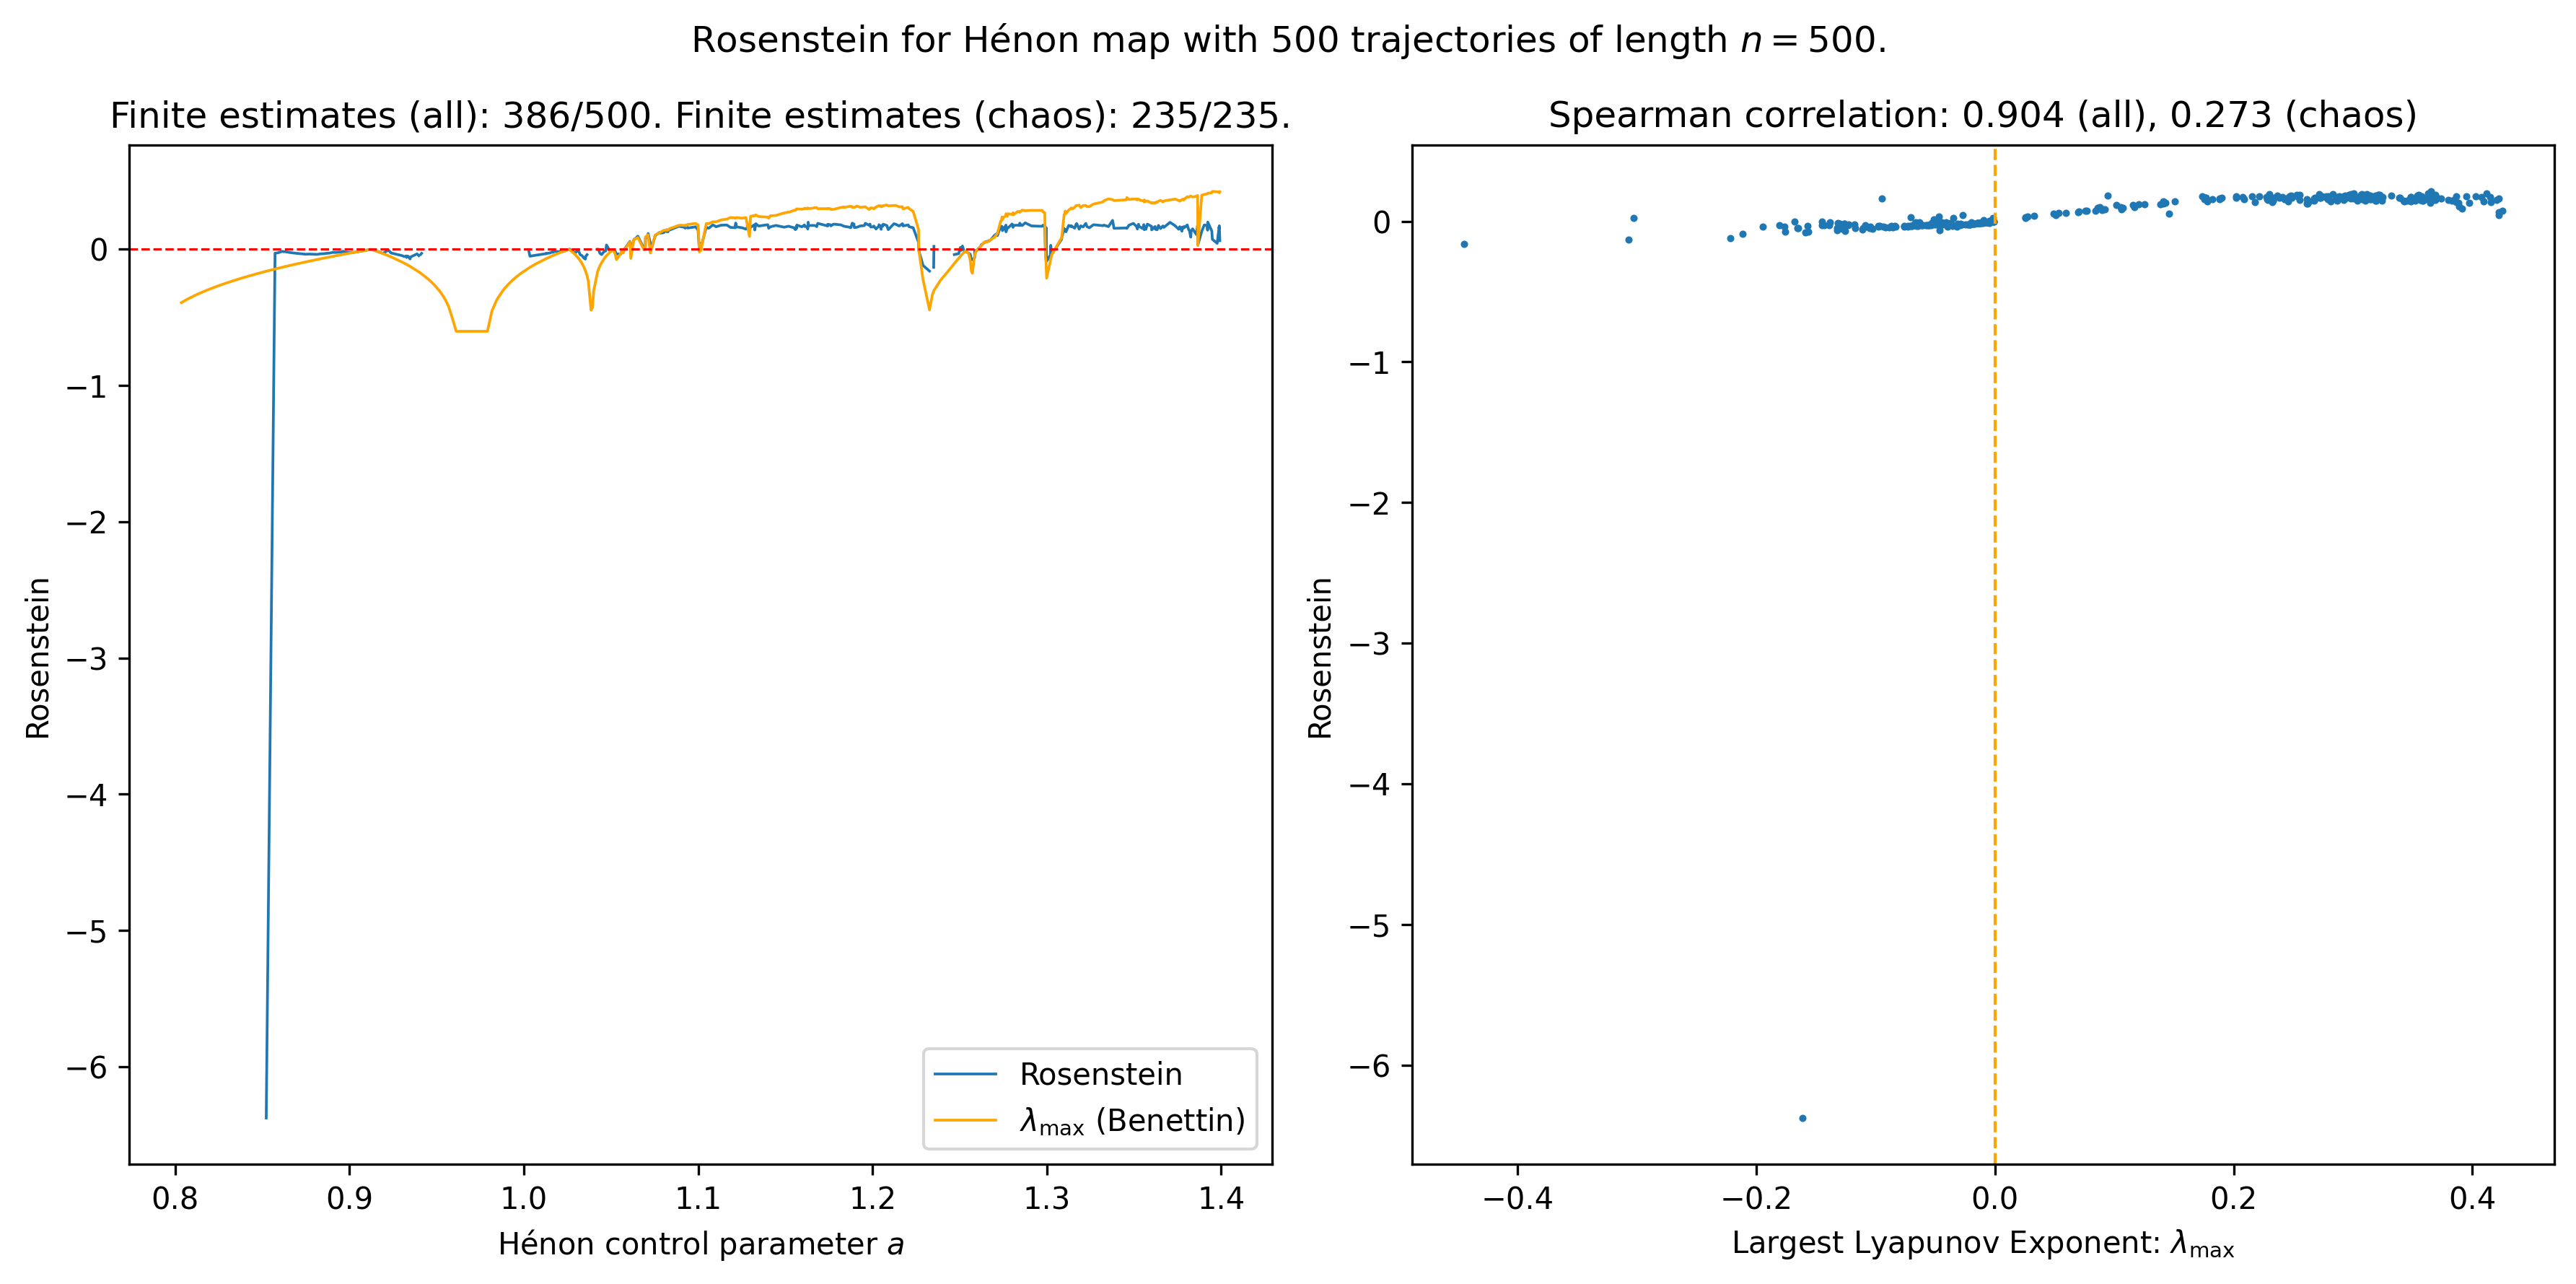

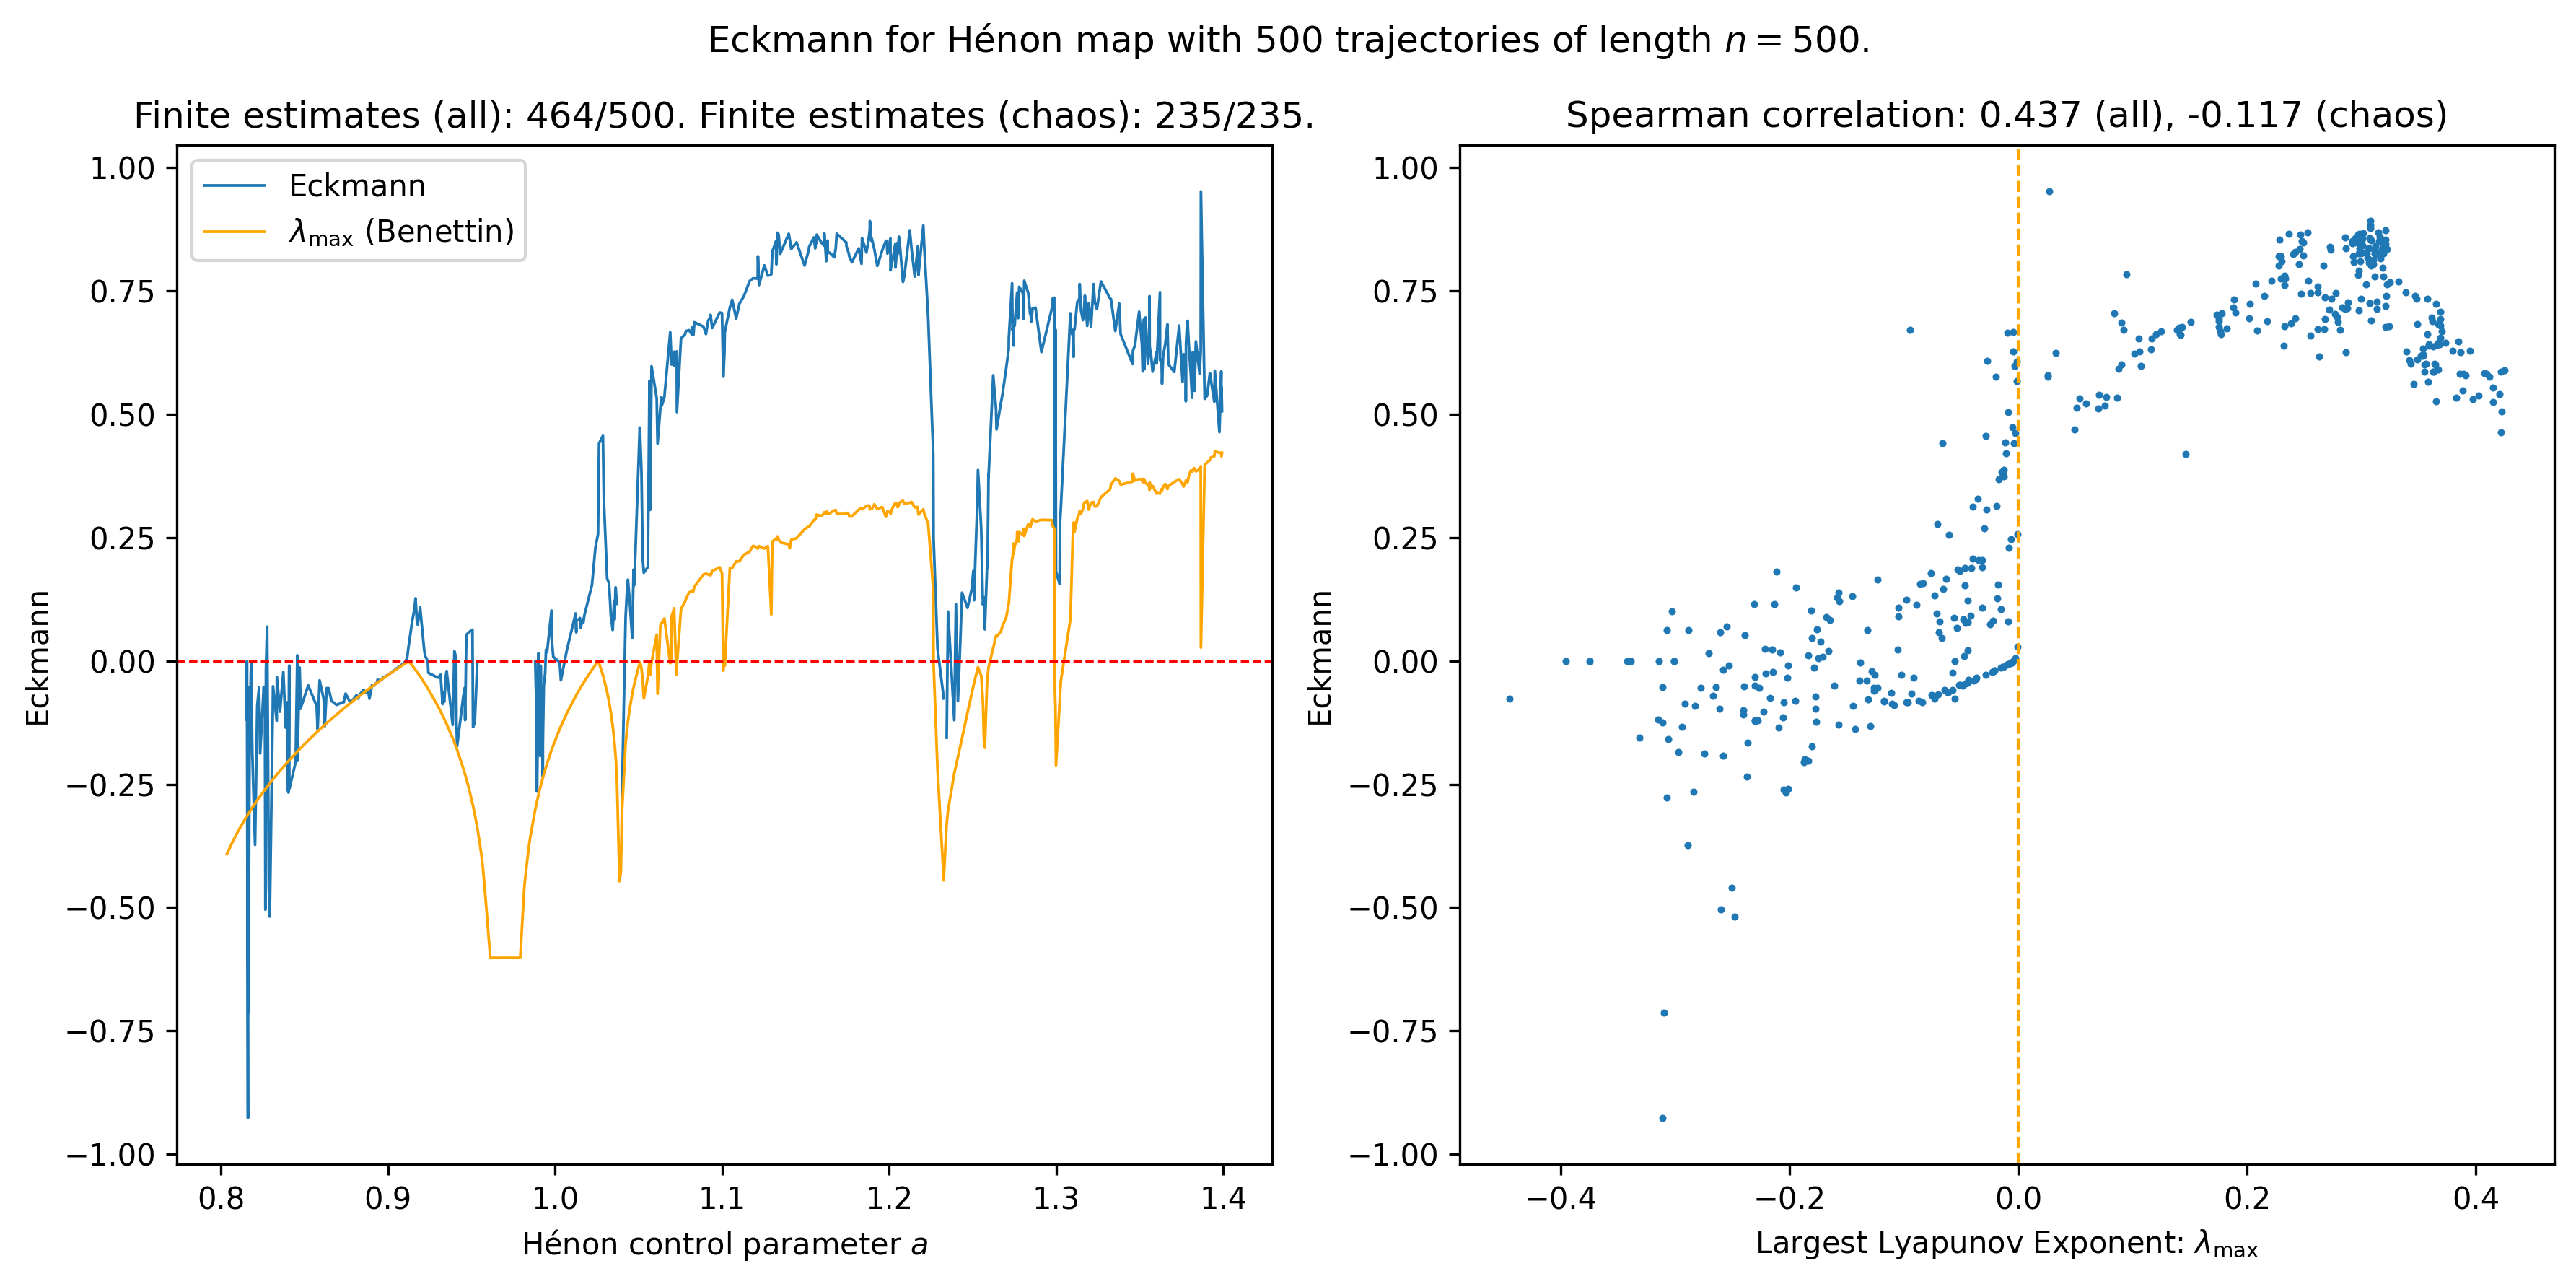

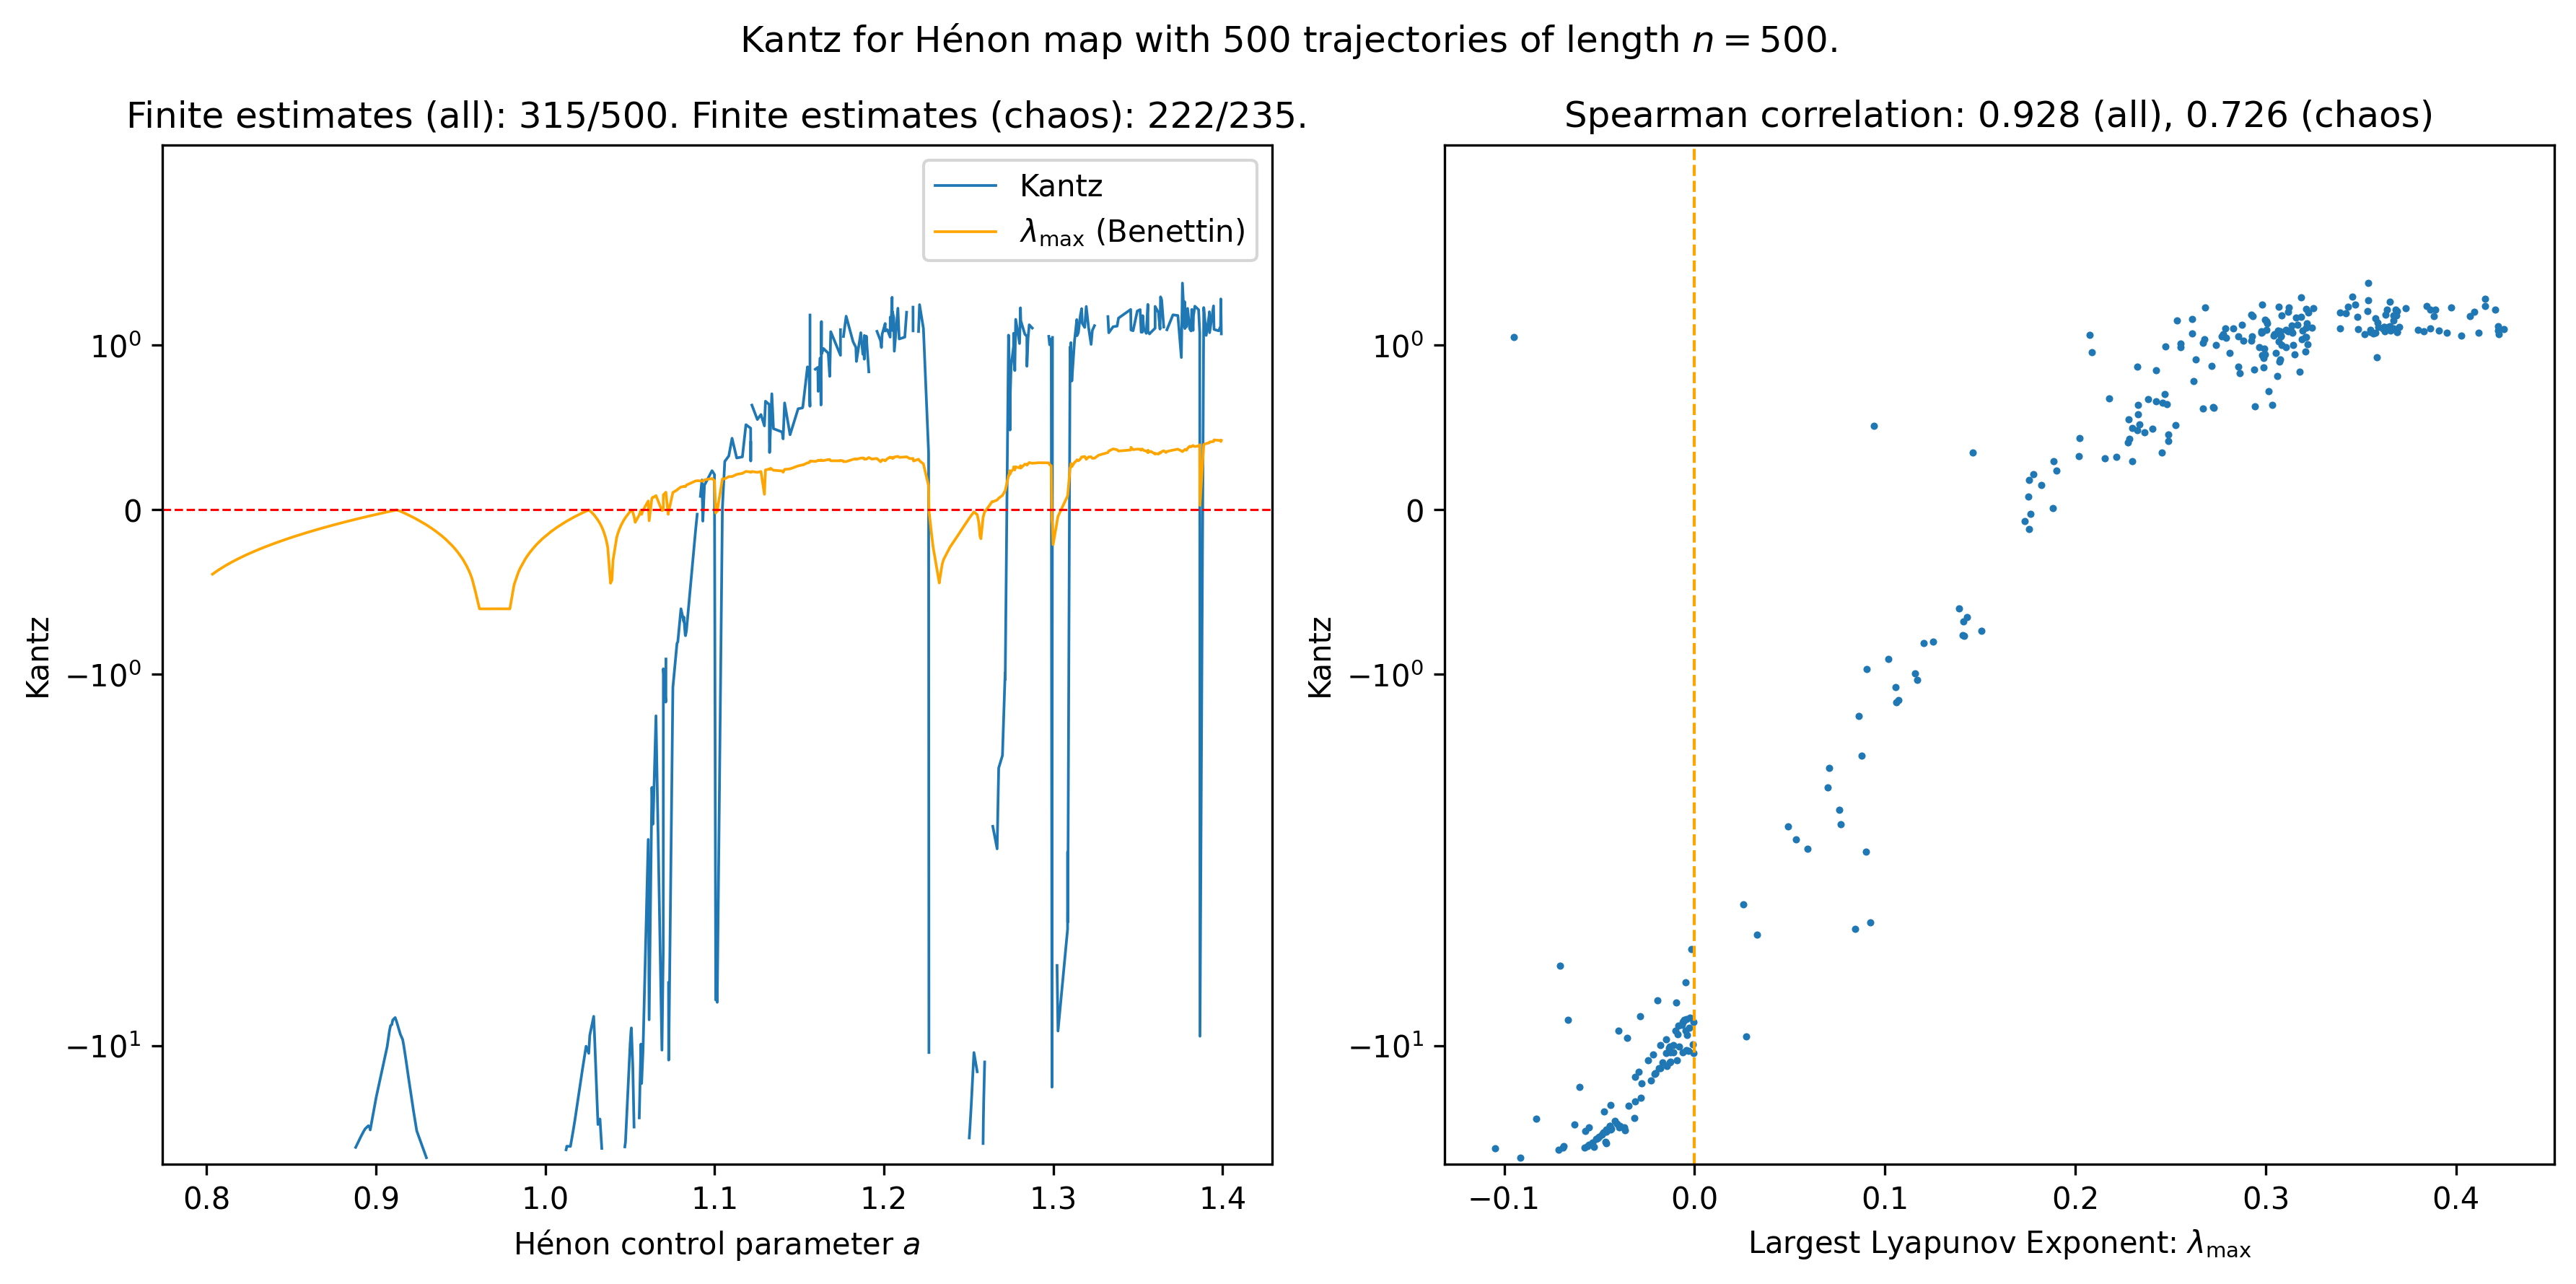

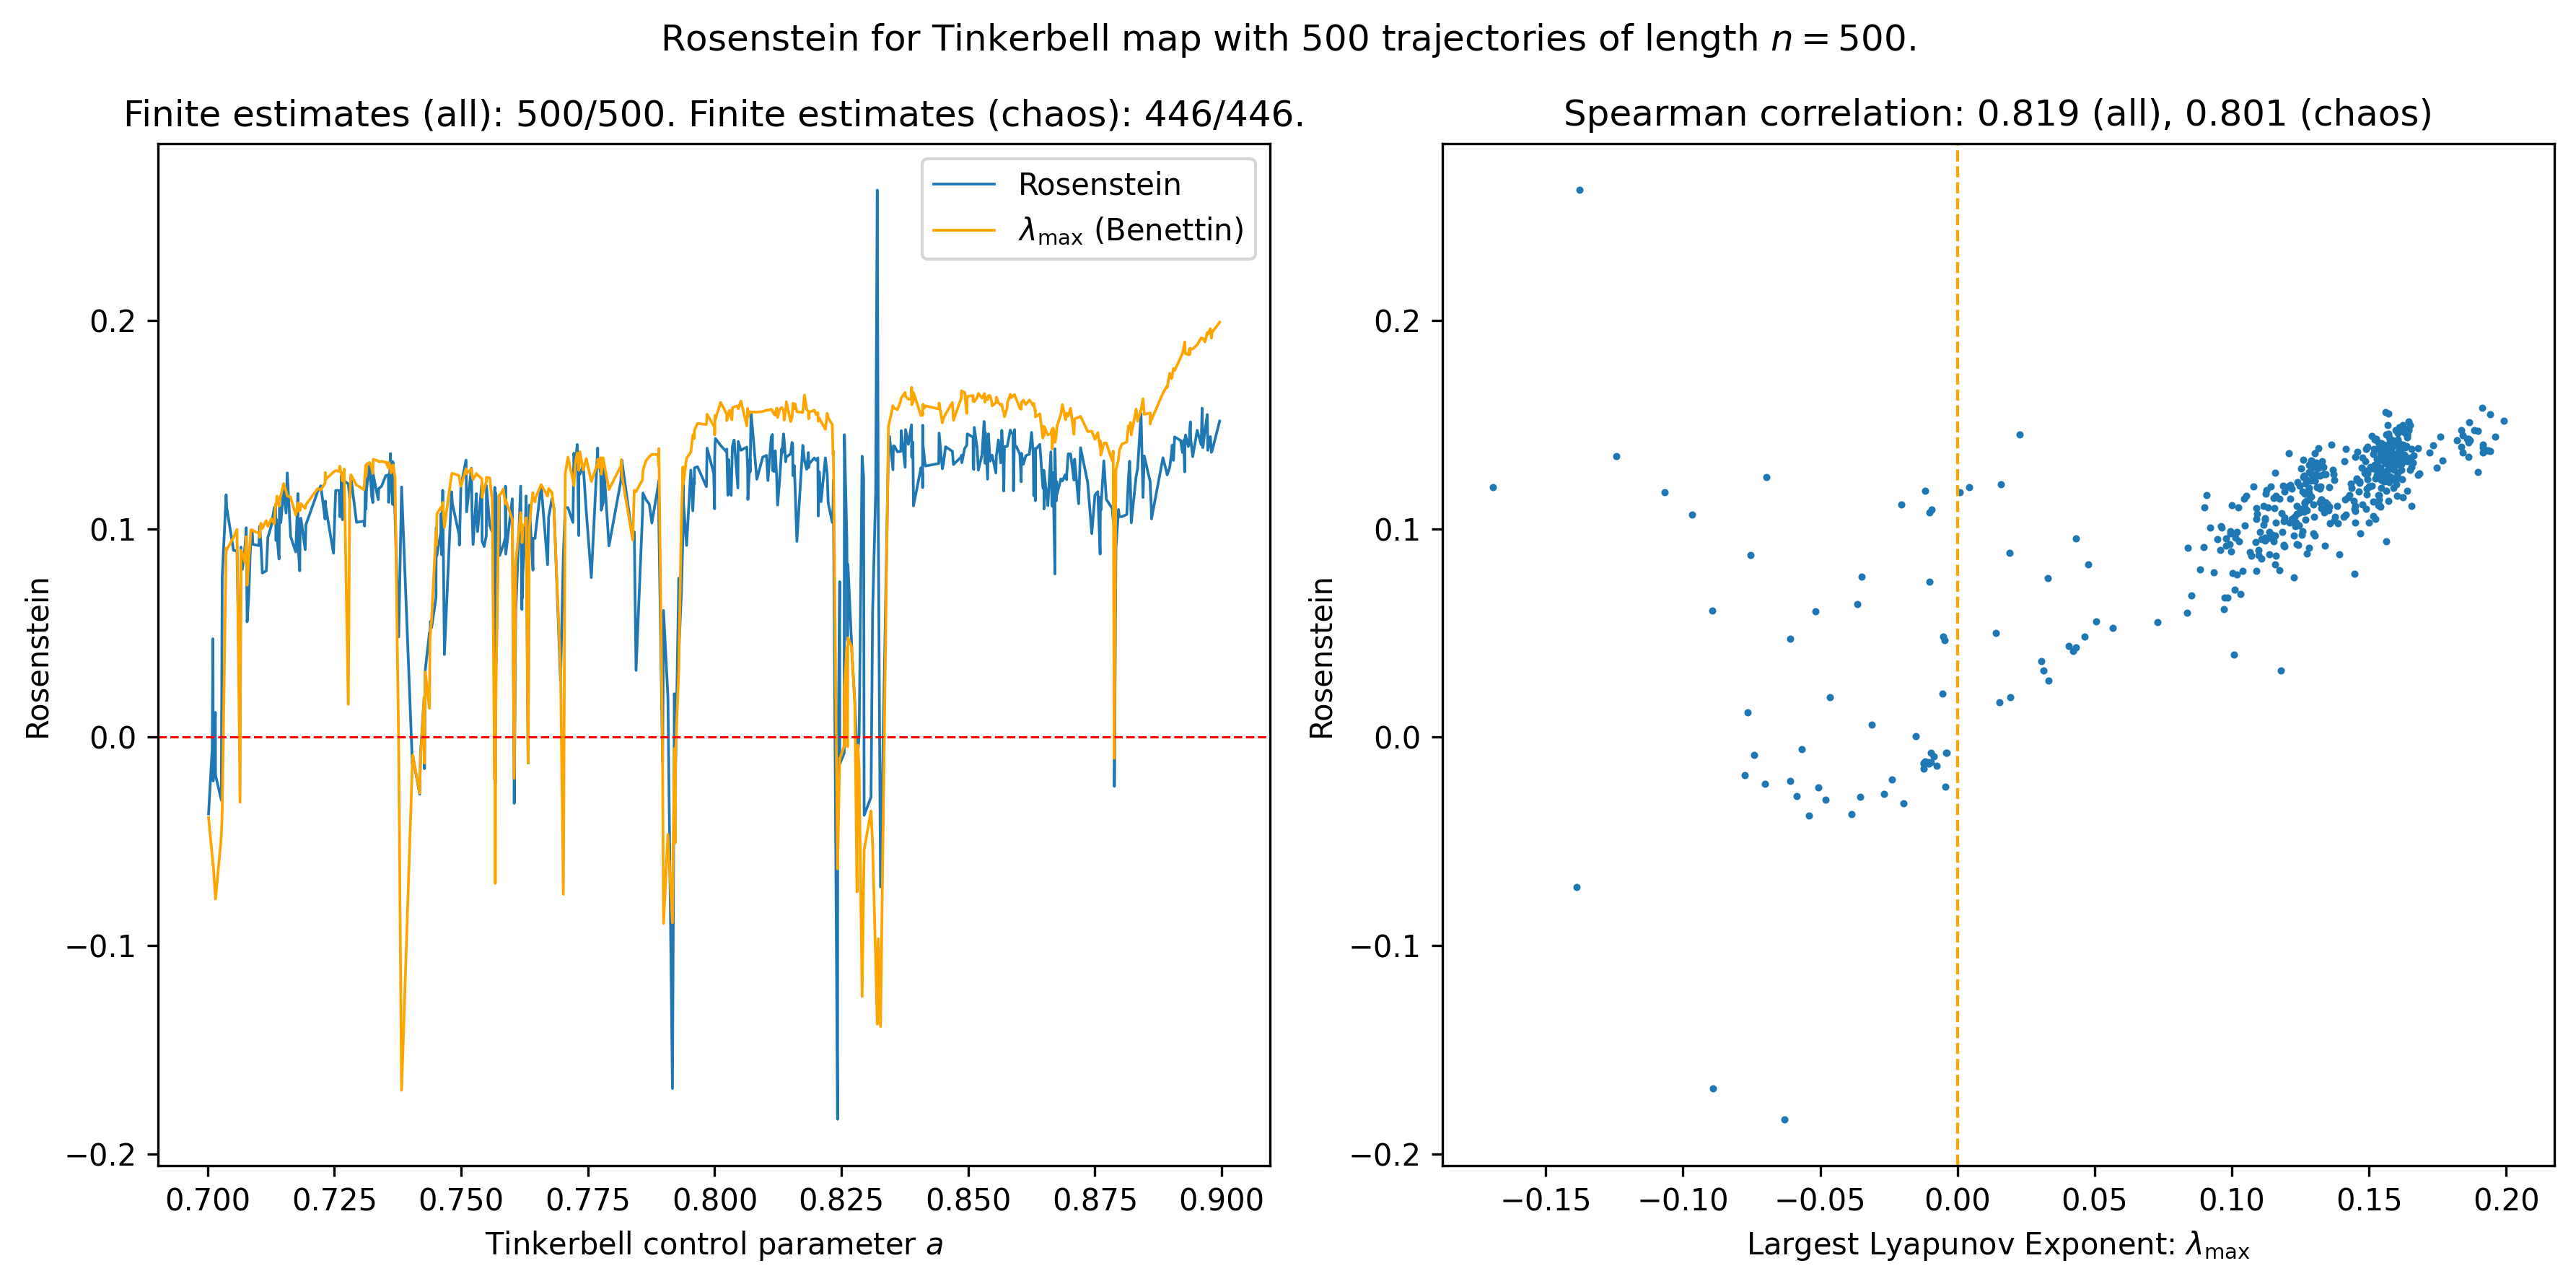

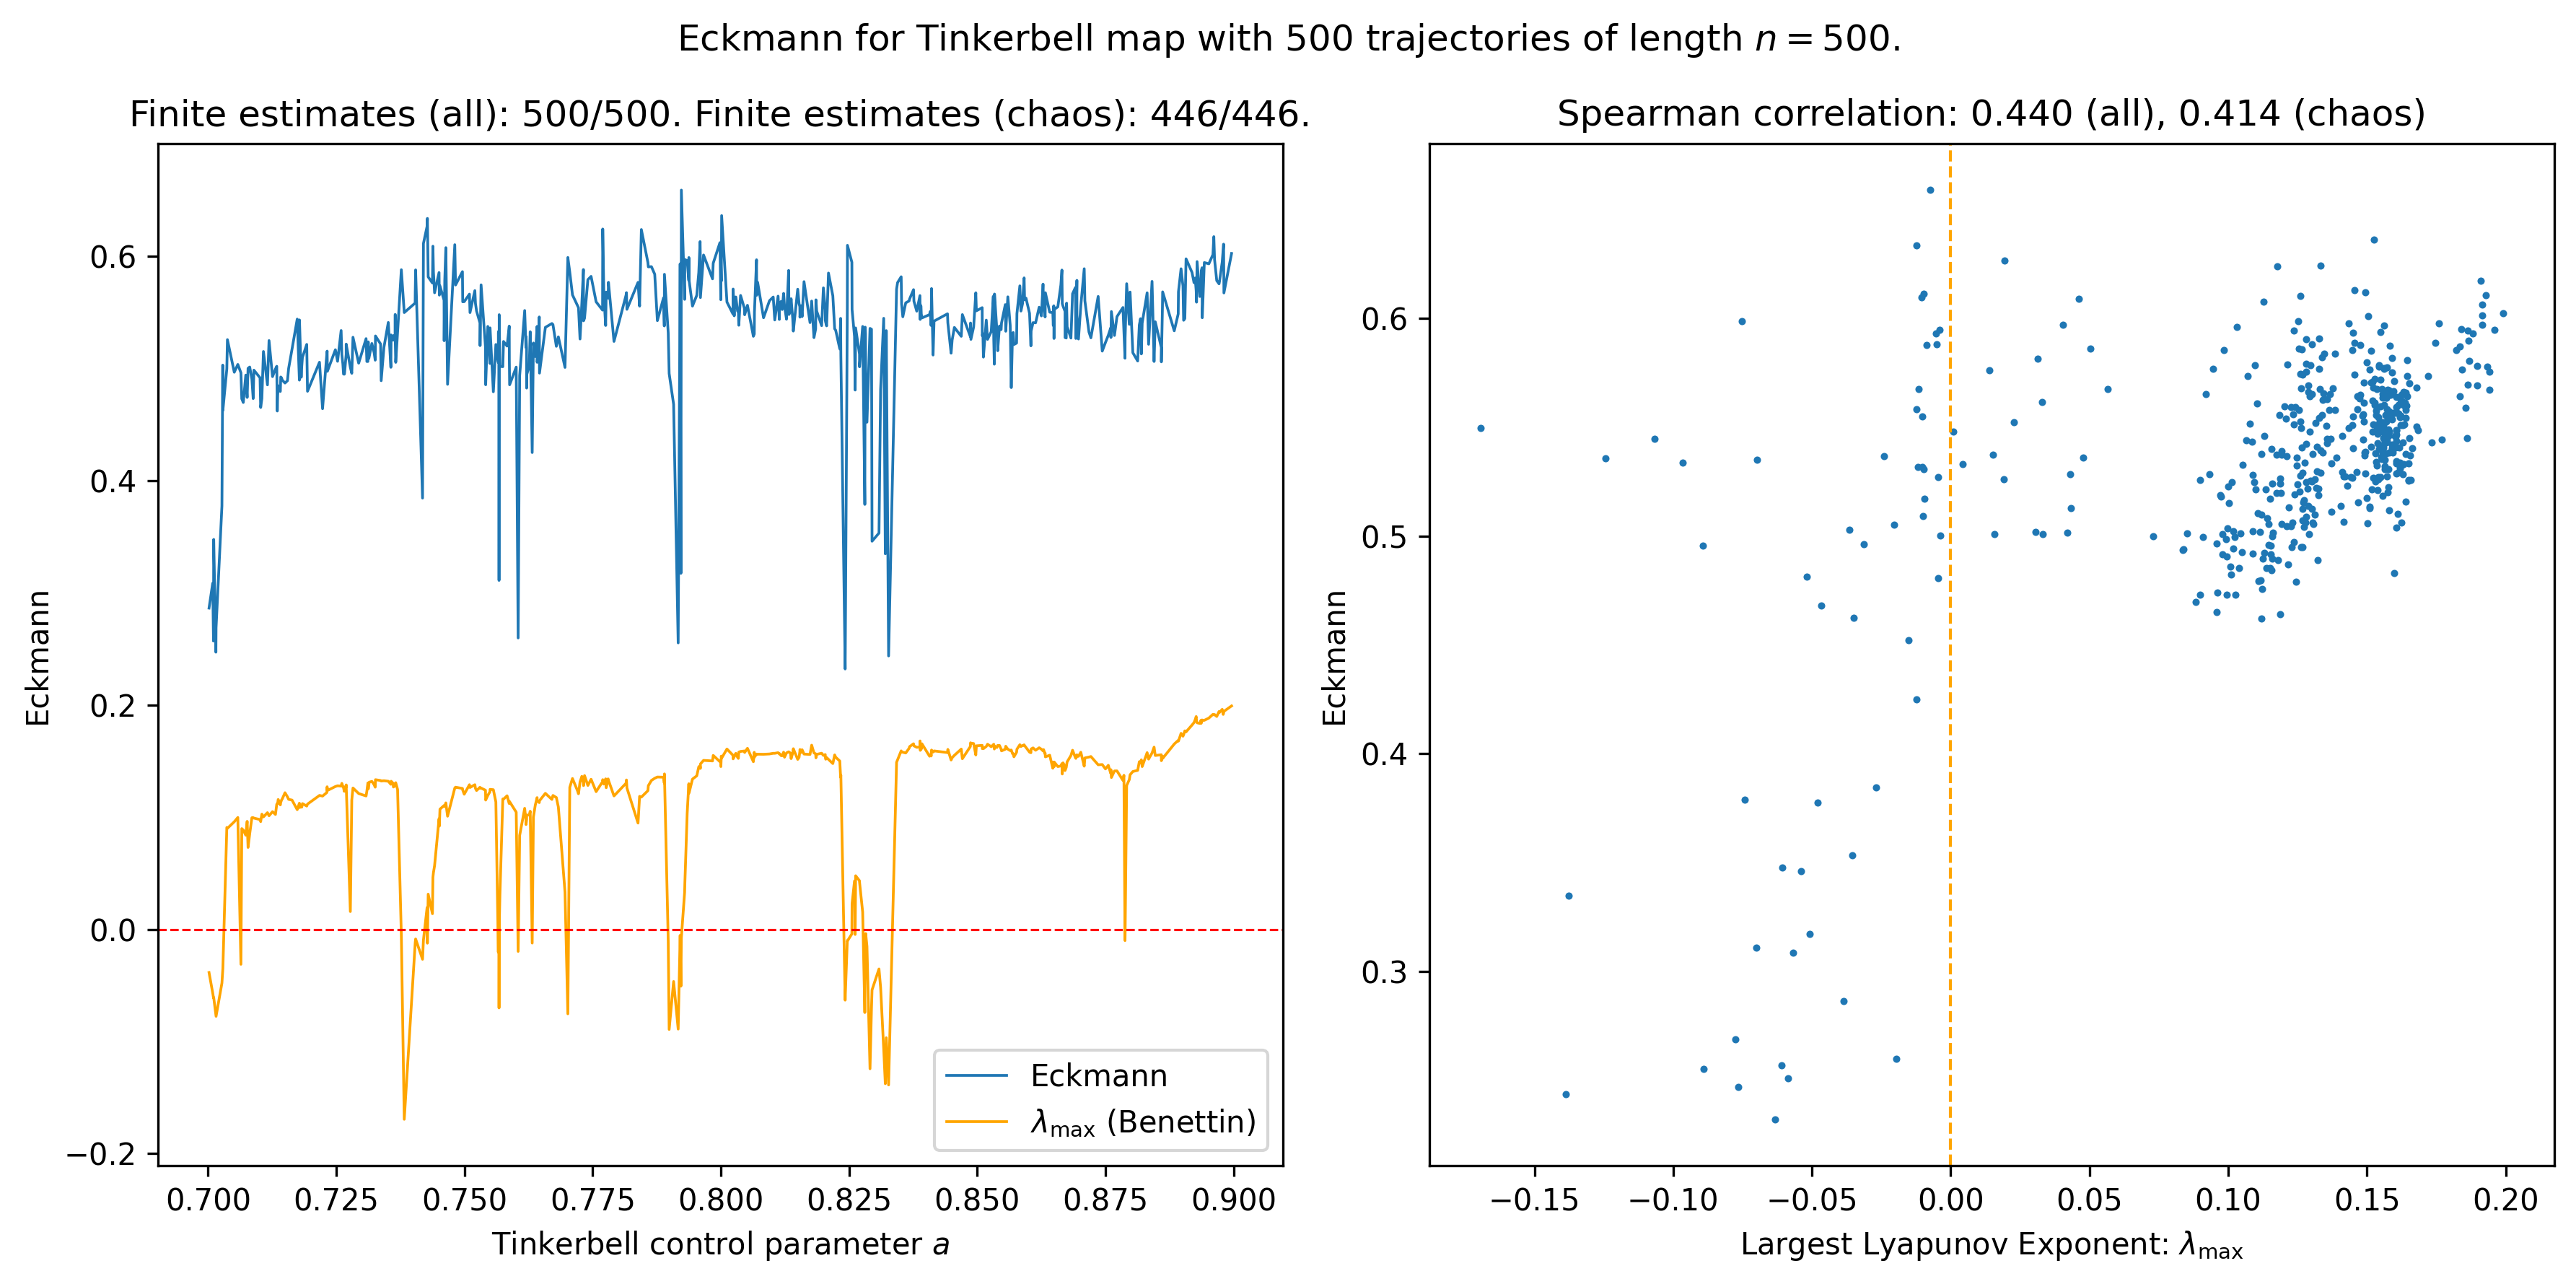

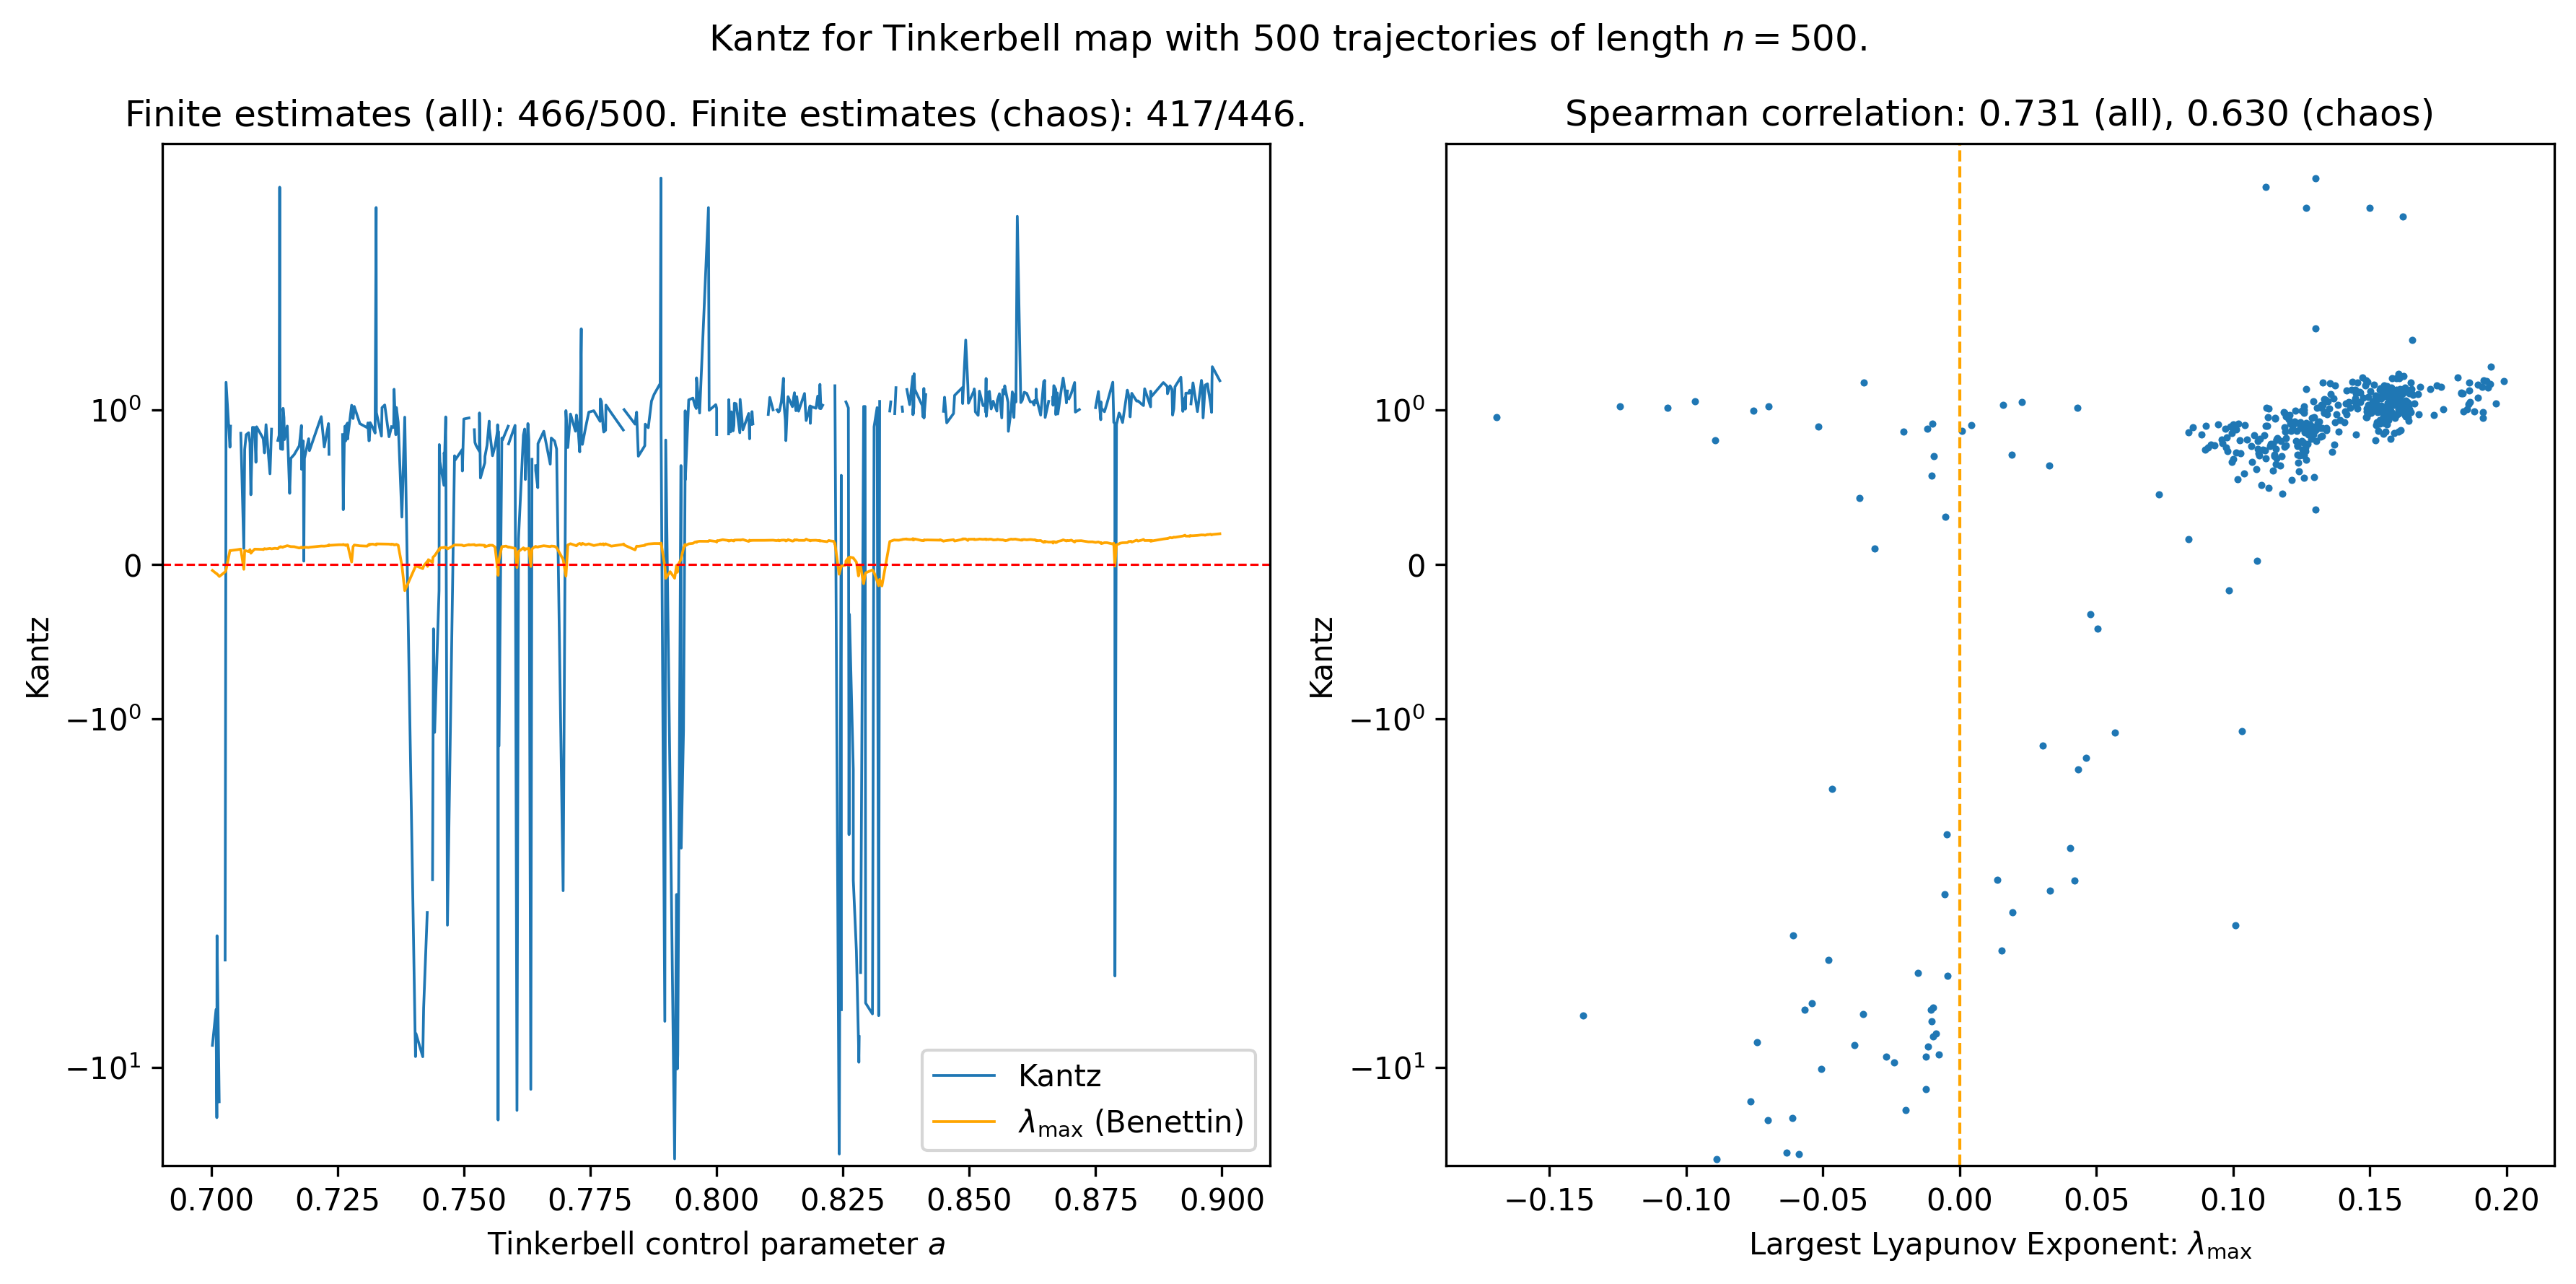

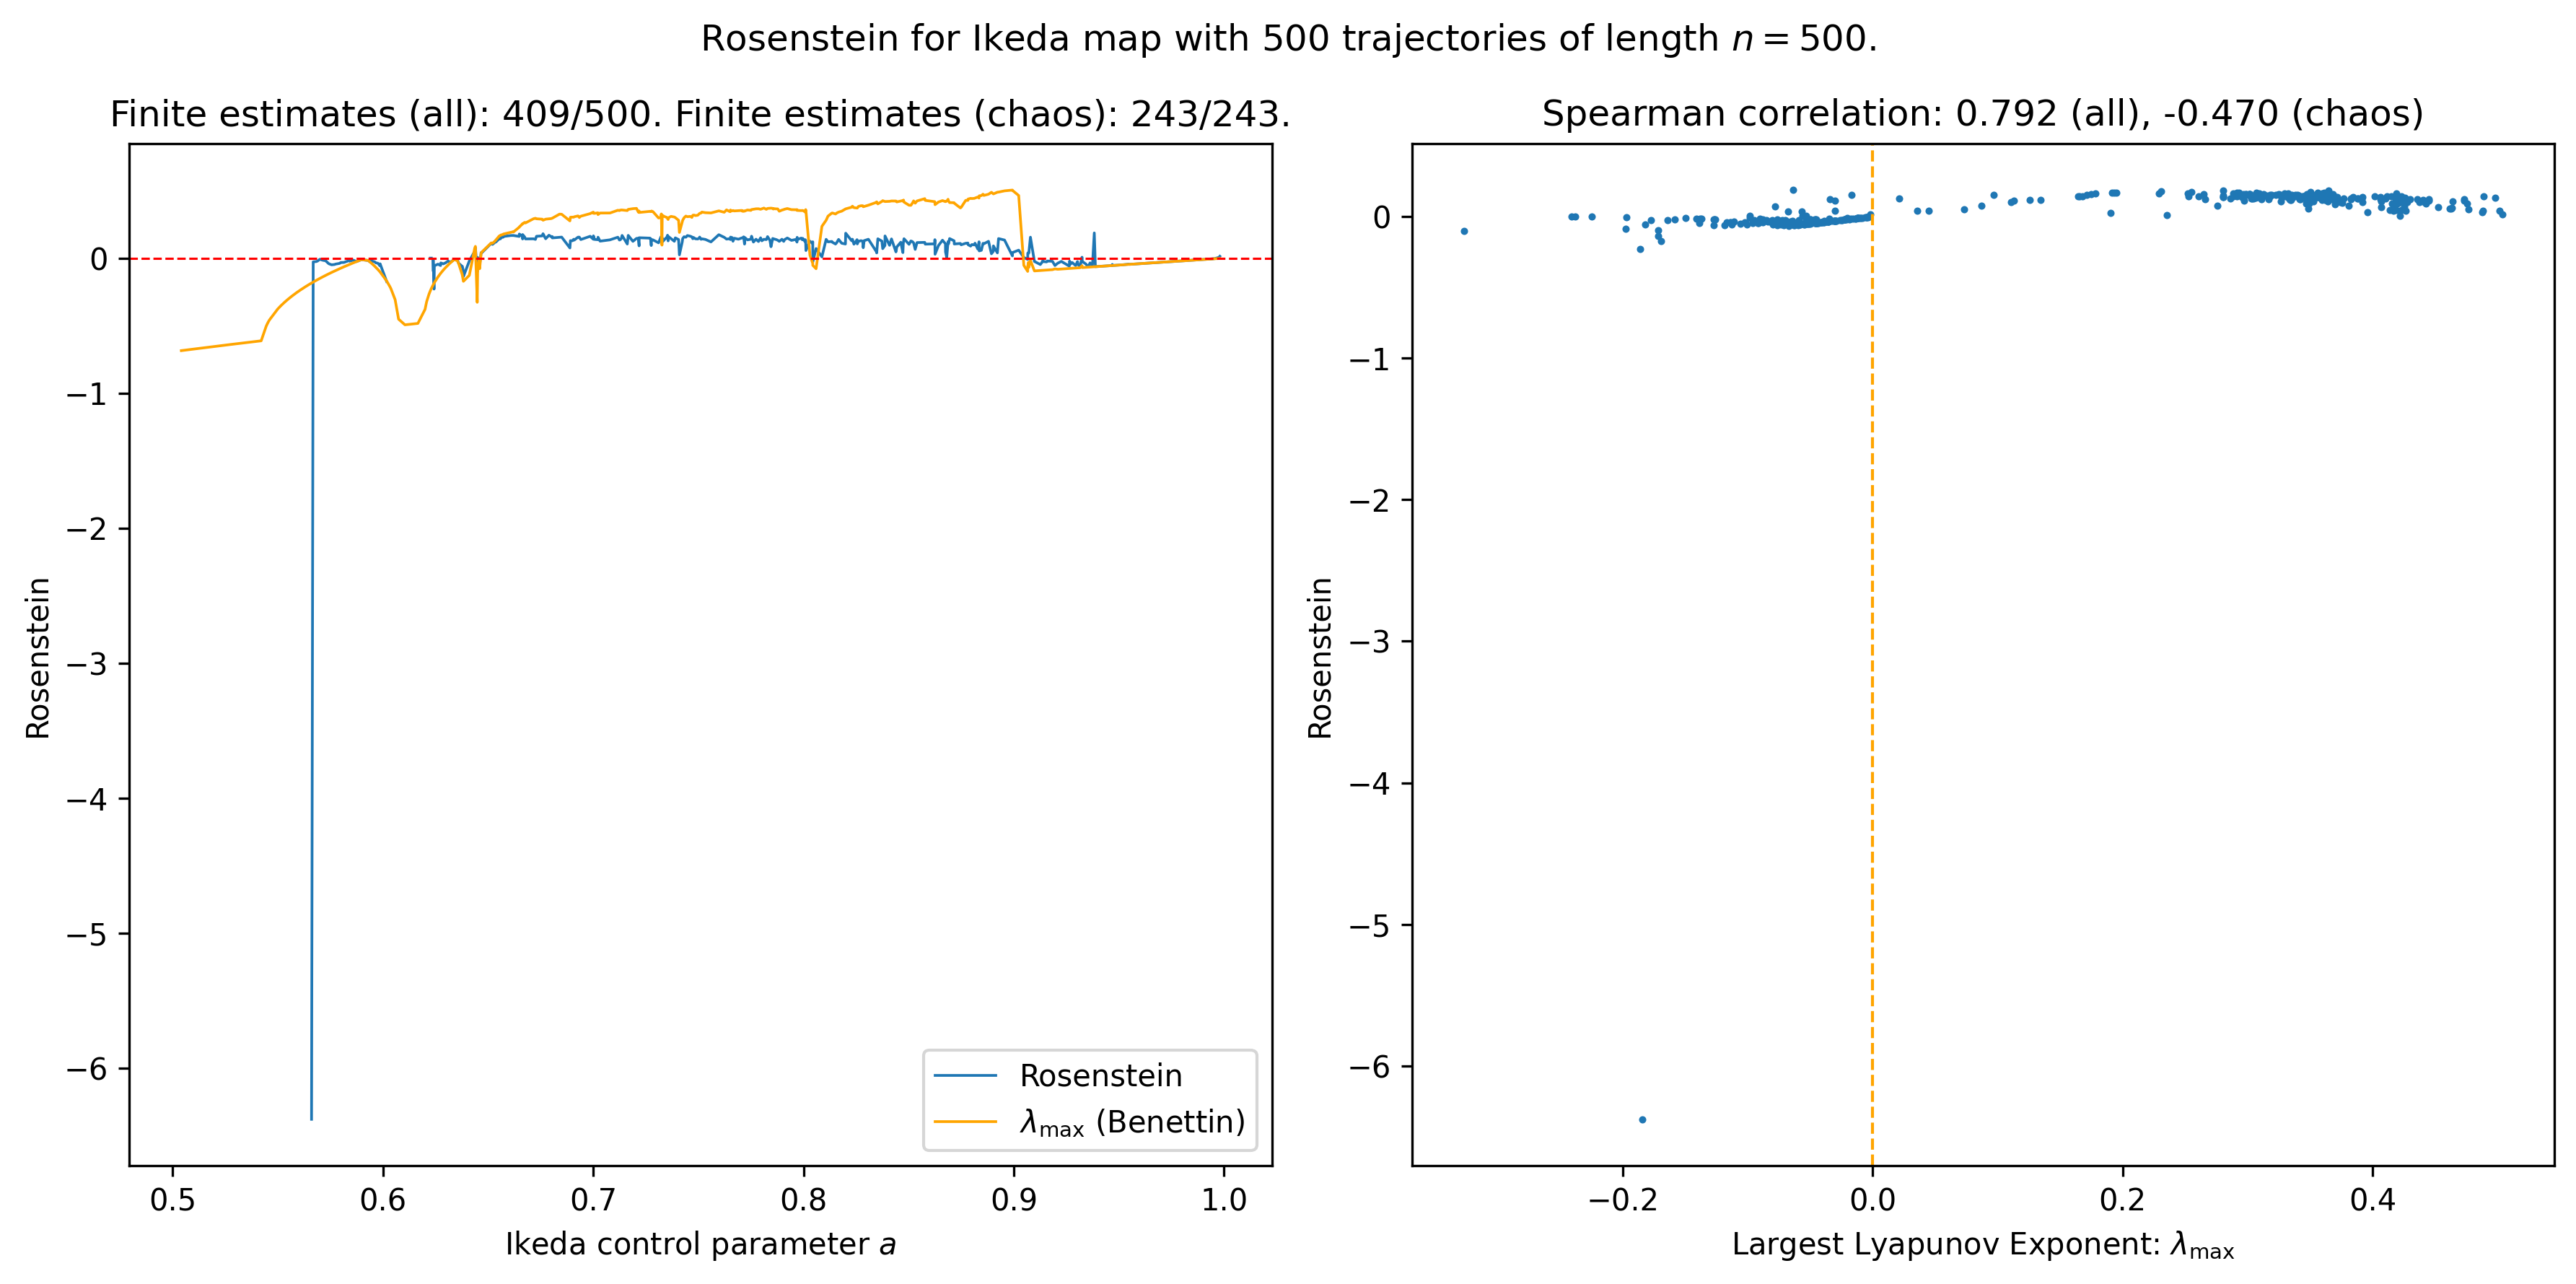

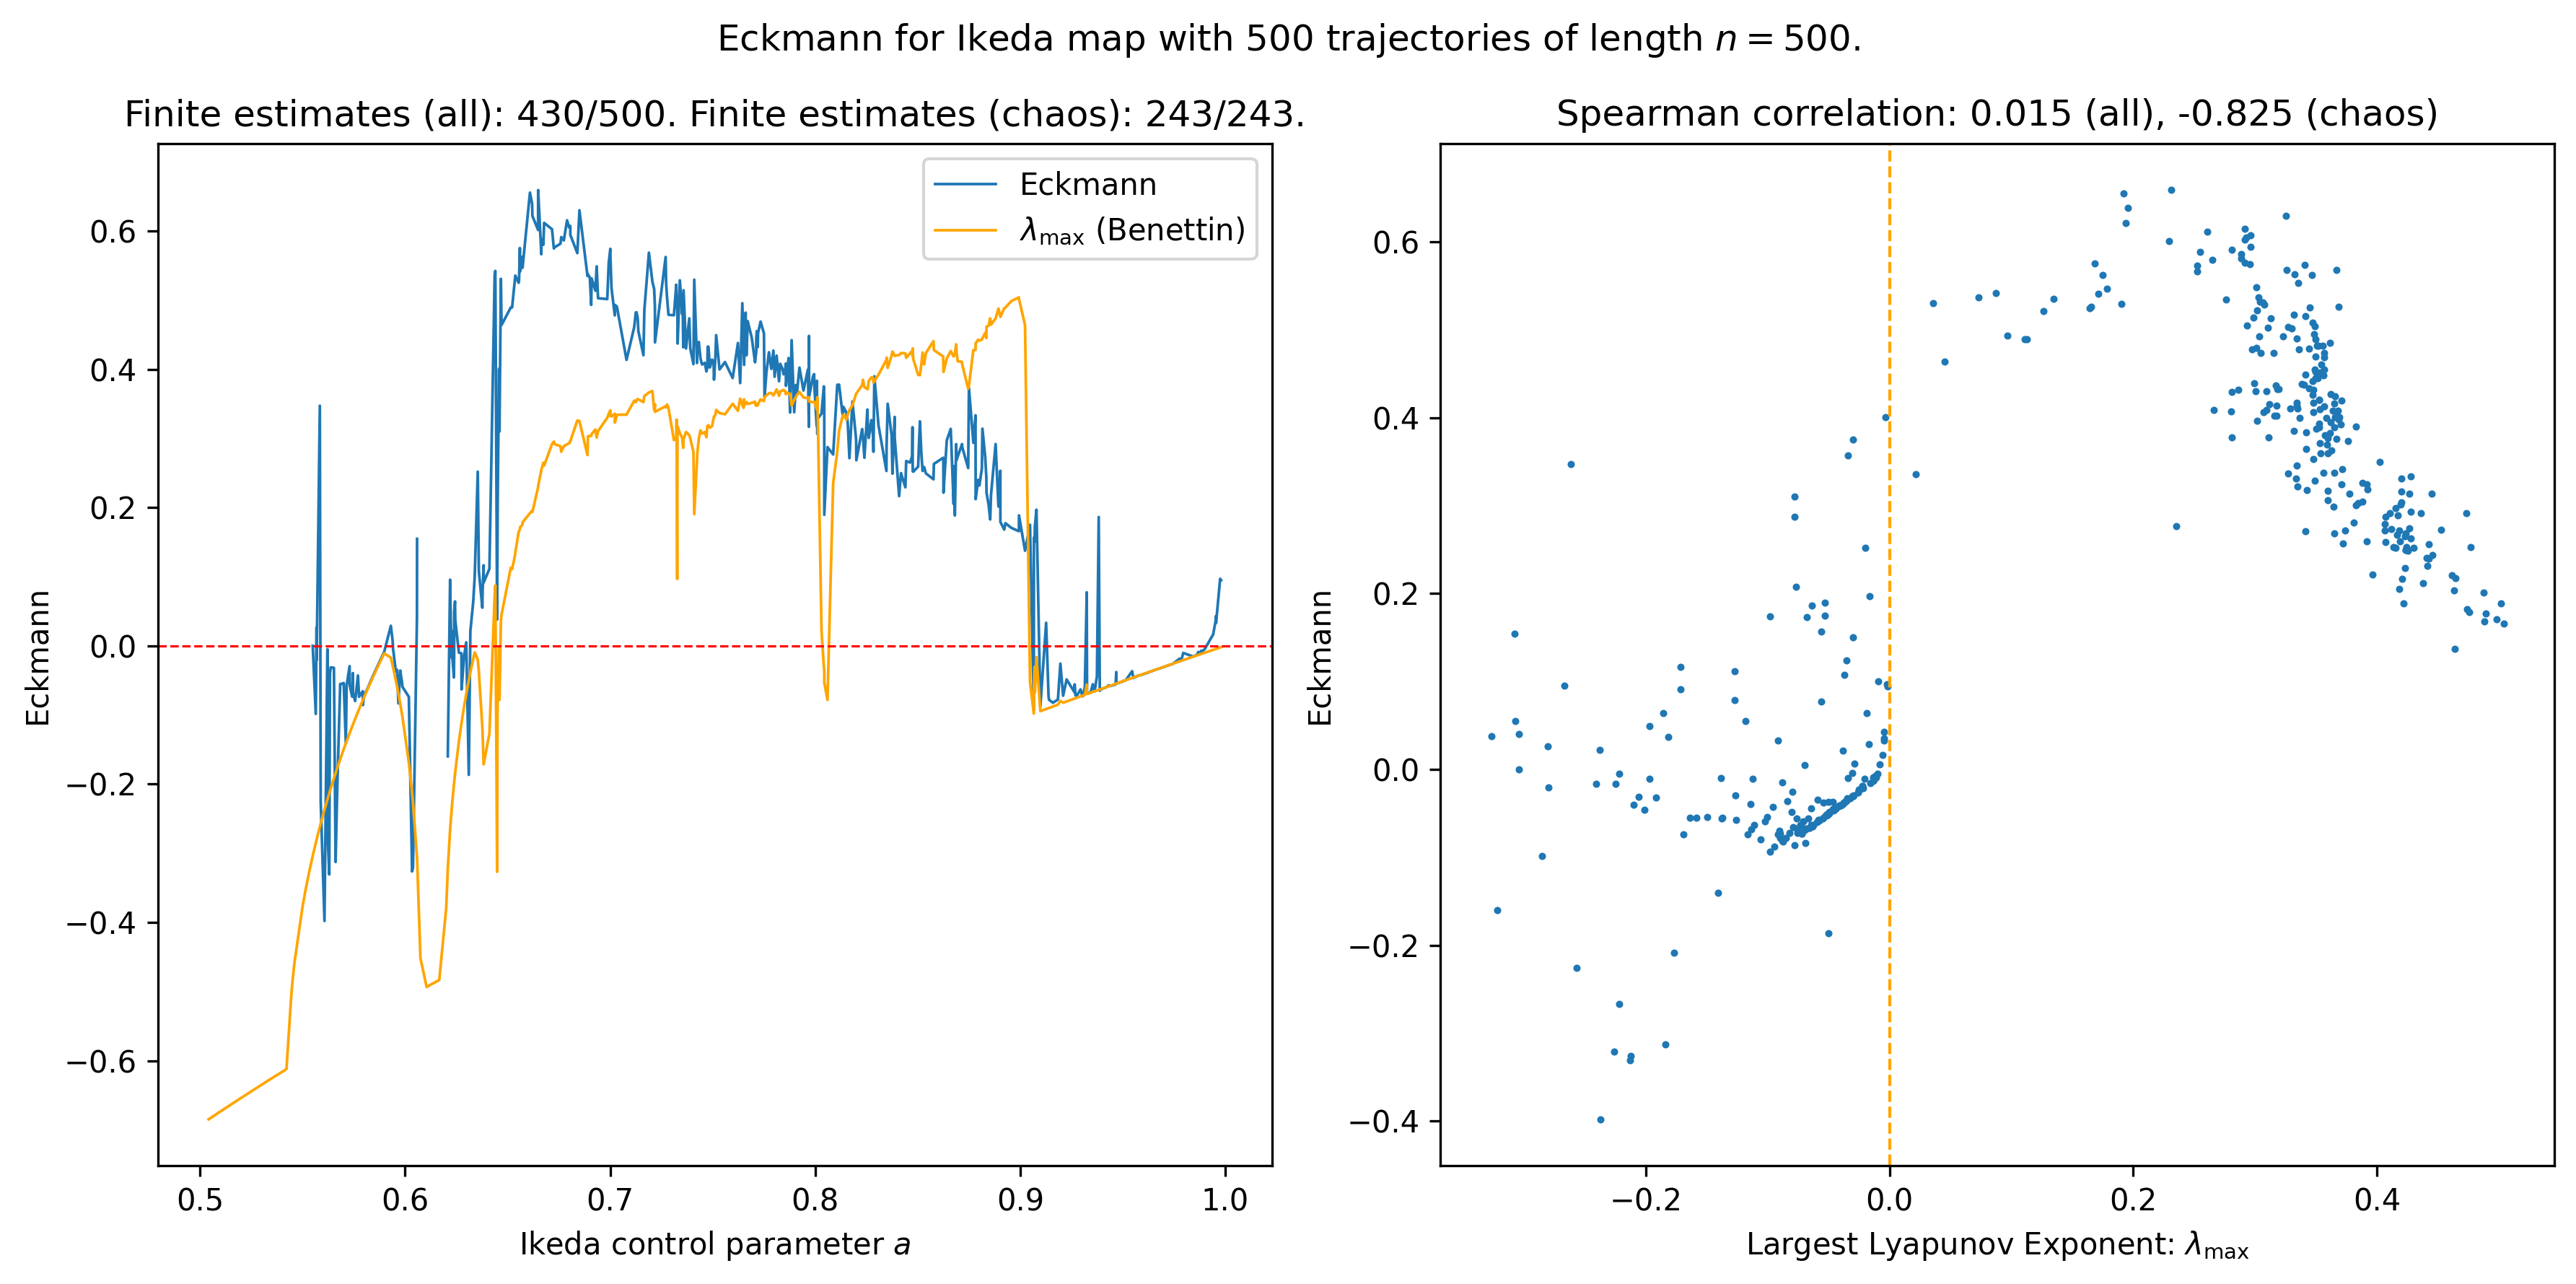

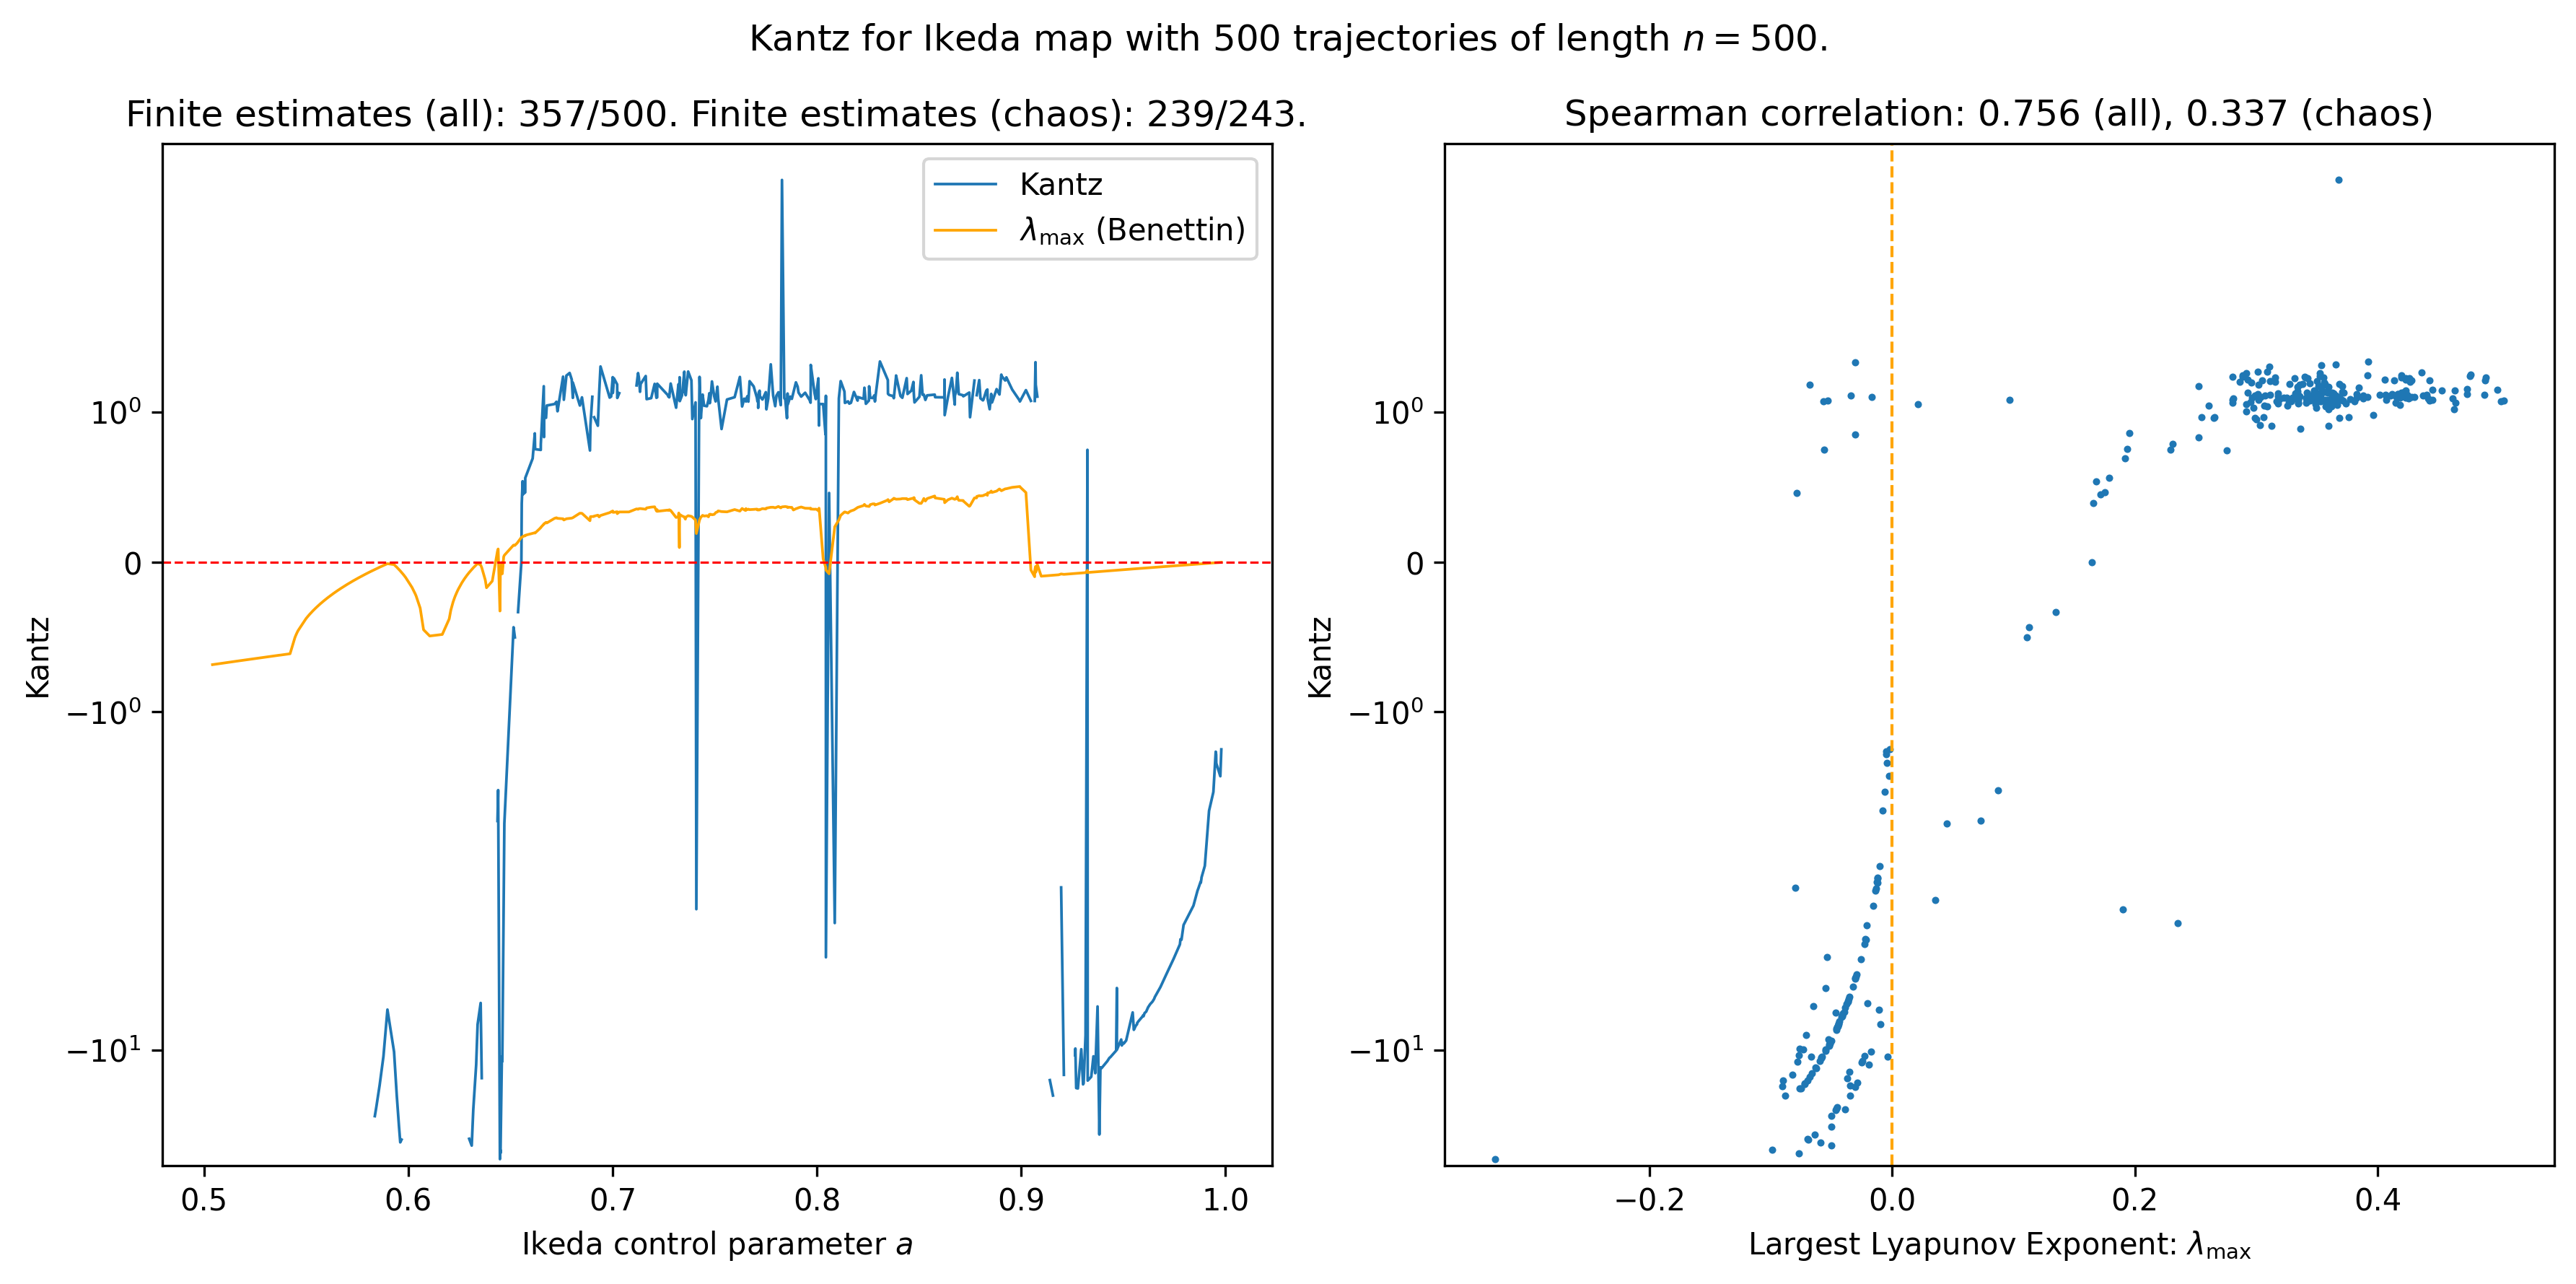

In [43]:
all_results_classical = {}
for sys_info in [
    ["Logistic", "r", logistic_trajectories, logistic_control_params, logistic_lces],
    ["Hénon", "a", henon_trajectories, henon_control_params, henon_lces],
    ["Tinkerbell", "a", tinkerbell_trajectories, tinkerbell_control_params, tinkerbell_lces],
    ["Ikeda", "a", ikeda_trajectories, ikeda_control_params, ikeda_lces],
]:
    all_results_classical |= generate_classical_estimates(*sys_info, show_plot=False)


In [44]:
with open(f"outputs/data/CLASSIC_benchmarks_{LENGTH}.pkl", "wb") as file:
    pickle.dump(all_results_classical)


for result in all_results_classical:
    print(result, all_results_classical[result])

('Rosenstein', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=0.315562774161362, pvalue=5.050653972014468e-13), 'pos_spearmanr': SpearmanrResult(correlation=-0.5122087384433792, pvalue=7.186381307162386e-27), 'classification_f1': 0.9756245621177125, 'regression_neg_mean_absolute': -0.4406322677962325, 'pos_regression_neg_mean_absolute': -0.6229788472382923}
('Eckmann', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=0.04208418779707772, pvalue=0.34768359121737913), 'pos_spearmanr': SpearmanrResult(correlation=-0.5534773467452693, pvalue=5.811870107485521e-32), 'classification_f1': 0.9358333621748589, 'regression_neg_mean_absolute': -0.4811323674516693, 'pos_regression_neg_mean_absolute': -0.63880519392117}
('Kantz', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=0.7855548412352041, pvalue=1.0563510870230525e-87), 'pos_spearmanr': SpearmanrResult(correlation=0.6589314971068055, pvalue=8.375265056206532e-49), 'classification_f1': 0.9931496565058209, 're